# Final Project

### Import libraries and define random seed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

import random
import math
import os
import zipfile
import shutil

import torch
from torch import nn
import torchvision

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
# See if torchmetrics exists, if not, install it
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.2 MB/s eta 0:00:00
mlxtend version: 0.23.1
0.23.1


In [ ]:
# Get the number of available CPU cores on the system
NUM_WORKERS = os.cpu_count()

# Define a Random Seed for reproducability
RANDOM_SEED = 26

torch.cuda.manual_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### Load and unzip datasets

Πρέπει να κάνουμε upload το αρχείο Data Τελικής Εργασίας.zip στο colab.

In [ ]:
# Delete 'Data Τελικής Εργασίας' folder
# os.chdir("/content/")
# shutil.rmtree('Data Τελικής Εργασίας')

In [ ]:
# List the contents of the /contents directory
target_directory = "/content"
contents = os.listdir(target_directory)
print(f"Contents are: {contents}")

Contents are: ['.config', 'model_11.pth', 'Data Τελικής Εργασίας.zip', 'sample_data']


In [ ]:
# Specify the path of the zip file
zip_file_path = "/content/Data Τελικής Εργασίας.zip"

# Specify the test directory for extraction
test_directory = "/content/Data Τελικής Εργασίας.zip/Data Τελικής Εργασίας"

# Specify the target directory for extraction
target_directory = "/content"

In [ ]:
# Check if the test directory exists
if not os.path.exists(test_directory):
  print(f"Extracting...")

  # Extract the contents of the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)
  print(f"Extraction completed.")

# List the contents of the target directory
contents = os.listdir(target_directory)
print(f"Contents of the directory [{target_directory}] are: {contents}")

Extracting...
Extraction completed.
Contents of the directory [/content] are: ['.config', 'model_11.pth', 'Data Τελικής Εργασίας', 'Data Τελικής Εργασίας.zip', 'sample_data']


In [ ]:
# Specify the path of the zip file
zip_file_path = "/content/Data Τελικής Εργασίας/Mask_DB.zip"

# Specify the test directory for extraction
test_directory = "/content/Data Τελικής Εργασίας/with_mask"

# Specify the target directory for extraction
target_directory = "/content/Data Τελικής Εργασίας/Mask_DB"

# Check if the test directory exists
if not os.path.exists(test_directory):
  print(f"Extracting...")

  # Create the target directory
  os.makedirs(target_directory, exist_ok=True)

  # Extract the contents of the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)
  print(f"Extraction completed.")

# List the contents of the target directory
contents = os.listdir(target_directory)
print(f"Contents of the directory [{target_directory}] are: {contents}")

Extracting...
Extraction completed.
Contents of the directory [/content/Data Τελικής Εργασίας/Mask_DB] are: ['without_mask', 'with_mask', 'mask_incorrect_use']


In [ ]:
# Specify the path of the zip file
zip_file_path = "/content/Data Τελικής Εργασίας/Data_Receptors.zip"

# Specify the test directory for extraction
test_directory = "/content/Data Τελικής Εργασίας/with_mask"

# Specify the target directory for extraction
target_directory = "/content/Data Τελικής Εργασίας/Data_Receptors"

# Check if the test directory exists
if not os.path.exists(test_directory):
  print(f"Extracting...")

  # Create the target directory
  os.makedirs(target_directory, exist_ok=True)

  # Extract the contents of the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)
  print(f"Extraction completed.")

# List the contents of the target directory
contents = os.listdir(target_directory)
print(f"Contents of the directory [{target_directory}] are: {contents}")

Extracting...
Extraction completed.
Contents of the directory [/content/Data Τελικής Εργασίας/Data_Receptors] are: ['Test_Features.csv', 'Train_Labels.csv', 'Train_Features.csv']


### Device Agnostic Code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # If GPU is available, it will be used
device

'cuda'

## Part 1

### Split data

In [ ]:
# Find out number of images in folders
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

folder_path = "/content/Data Τελικής Εργασίας/Mask_DB"
walk_through_dir(folder_path)

There are 3 directories and 0 images in '/content/Data Τελικής Εργασίας/Mask_DB'.
There are 0 directories and 1044 images in '/content/Data Τελικής Εργασίας/Mask_DB/without_mask'.
There are 0 directories and 1044 images in '/content/Data Τελικής Εργασίας/Mask_DB/with_mask'.
There are 0 directories and 56 images in '/content/Data Τελικής Εργασίας/Mask_DB/mask_incorrect_use'.


In [ ]:
# Split percentages
train_per = 0.6 # 60%
val_per = 0.2 # 20%
test_per = 0.2 # 20%

# Get the list of files in each directory
with_mask_dir = folder_path + "/with_mask"
without_mask_dir = folder_path + "/without_mask"
with_mask_files = os.listdir(with_mask_dir)
without_mask_files = os.listdir(without_mask_dir)

# Calculate the number of files for the training, validation, and test sets
num_train_with_mask = math.ceil(train_per * len(with_mask_files))
num_val_with_mask = math.ceil(val_per * len(with_mask_files))
num_test_with_mask = len(with_mask_files) - num_train_with_mask - num_val_with_mask

num_train_without_mask = math.ceil(train_per * len(without_mask_files))
num_val_without_mask = math.ceil(val_per * len(without_mask_files))
num_test_without_mask = len(without_mask_files) - num_train_without_mask - num_val_without_mask


# Randomly select files for the training, validation, and test sets
train_with_mask_files, temp_with_mask_files = random_split(with_mask_files, [num_train_with_mask, len(with_mask_files) - num_train_with_mask])
val_with_mask_files, test_with_mask_files = random_split(temp_with_mask_files, [num_val_with_mask, num_test_with_mask])

train_without_mask_files, temp_without_mask_files = random_split(without_mask_files, [num_train_without_mask, len(without_mask_files) - num_train_without_mask])
val_without_mask_files, test_without_mask_files = random_split(temp_without_mask_files, [num_val_without_mask, num_test_without_mask])

In [ ]:
# Function to copy files from source to destination
def copy_images(source_dir, destination_dir, file_list):
  for file_name in file_list:
    source_path = os.path.join(source_dir, file_name)
    destination_path = os.path.join(destination_dir, file_name)
    shutil.copy2(source_path, destination_path)

# Create train directory
train_dir = folder_path + "/split_dataset/train_dir"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(train_dir+"/with_mask", exist_ok=True)
os.makedirs(train_dir+"/without_mask", exist_ok=True)

# Create val directory
val_dir = folder_path + "/split_dataset/val_dir"
os.makedirs(val_dir, exist_ok=True)
os.makedirs(val_dir+"/with_mask", exist_ok=True)
os.makedirs(val_dir+"/without_mask", exist_ok=True)

# Create test directory
test_dir = folder_path + "/split_dataset/test_dir"
os.makedirs(test_dir, exist_ok=True)
os.makedirs(test_dir+"/with_mask", exist_ok=True)
os.makedirs(test_dir+"/without_mask", exist_ok=True)


# Copy files to the training set
copy_images(with_mask_dir, train_dir+"/with_mask", train_with_mask_files)
copy_images(without_mask_dir, train_dir+"/without_mask", train_without_mask_files)

# Copy files to the validation set
copy_images(with_mask_dir, val_dir+"/with_mask", val_with_mask_files)
copy_images(without_mask_dir, val_dir+"/without_mask", val_without_mask_files)

# Copy files to the test set
copy_images(with_mask_dir, test_dir+"/with_mask", test_with_mask_files)
copy_images(without_mask_dir, test_dir+"/without_mask", test_without_mask_files)

In [ ]:
folder_path = "/content/Data Τελικής Εργασίας/Mask_DB/split_dataset"
walk_through_dir(folder_path)

There are 3 directories and 0 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset'.
There are 2 directories and 0 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/train_dir'.
There are 0 directories and 627 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/train_dir/without_mask'.
There are 0 directories and 627 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/train_dir/with_mask'.
There are 2 directories and 0 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/val_dir'.
There are 0 directories and 209 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/val_dir/without_mask'.
There are 0 directories and 209 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/val_dir/with_mask'.
There are 2 directories and 0 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/test_dir'.
There are 0 directories and 208 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/test_dir/without_ma

### Define Transforms and Create Data Generators

In [ ]:
# Define transforms
# Augment train data -> In small datasets augmentations are essential
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=15), # Randomly rotate the image up to 15 degrees
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Randomly translate the image
    transforms.ToTensor()
])

# Don't augment val data, only reshape
val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [ ]:
# Use ImageFolder to create datasets, with image augmentations
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

val_data = datasets.ImageFolder(root=val_dir,
                                transform=val_transform,
                                target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

# Without image augmentations, test_transform has no augmentation
original_train_data = datasets.ImageFolder(root=train_dir,
                                           transform=test_transform,
                                           target_transform=None)

# Print the sizes of the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 1254
Validation set size: 418
Test set size: 416


In [ ]:
# Turn datasets into batches (DataGenerators)
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=True)

val_dataloader = DataLoader(val_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS,
                             pin_memory=True)

# Without augmentations
original_train_dataloader = DataLoader(original_train_data,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       num_workers=NUM_WORKERS,
                                       pin_memory=True)

# Without shuffling
original_test_dataloader = DataLoader(test_data,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=NUM_WORKERS,
                                      pin_memory=True)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} images")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE} images")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} images")

Length of train dataloader: 40 batches of 32 images
Length of val dataloader: 14 batches of 32 images
Length of test dataloader: 13 batches of 32 images


### Display images

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['with_mask', 'without_mask']

In [ ]:
# Display the dimensions of a random image from training set
targ_sample = 0
img, label = train_data[targ_sample][0], train_data[targ_sample][1]
img_Channels, img_Width, img_Height = img.shape

print(f"Image Channels: {img_Channels}")
print(f"Image Width: {img_Width}")
print(f"Image Height: {img_Height}")

Image Channels: 3
Image Width: 32
Image Height: 32


In [ ]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset, classes=None, n=10, columns = 5, display_shape=True, seed=None):
    if seed is not None:
        random.seed(seed)

    num_rows = math.ceil(n / columns)  # Calculate the number of rows needed
    plt.figure(figsize=(16, 8))

    for i in range(n):
        if i >= len(dataset):
            break

        targ_sample = random.randint(0, len(dataset) - 1)
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Create a subplot for each image
        plt.subplot(num_rows, 5, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        plt.imshow(targ_image_adjust.squeeze())

        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
            plt.title(title)

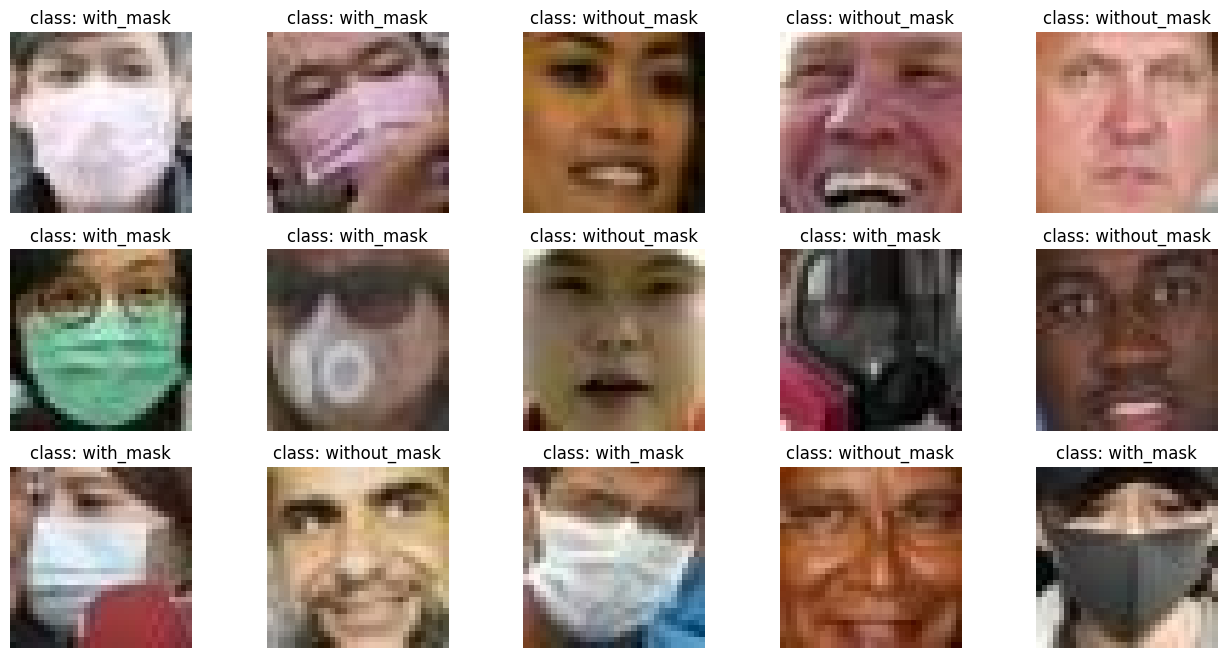

In [ ]:
display_random_images(original_train_data,
                      n=15,
                      classes=class_names,
                      seed=RANDOM_SEED,
                      display_shape=False)

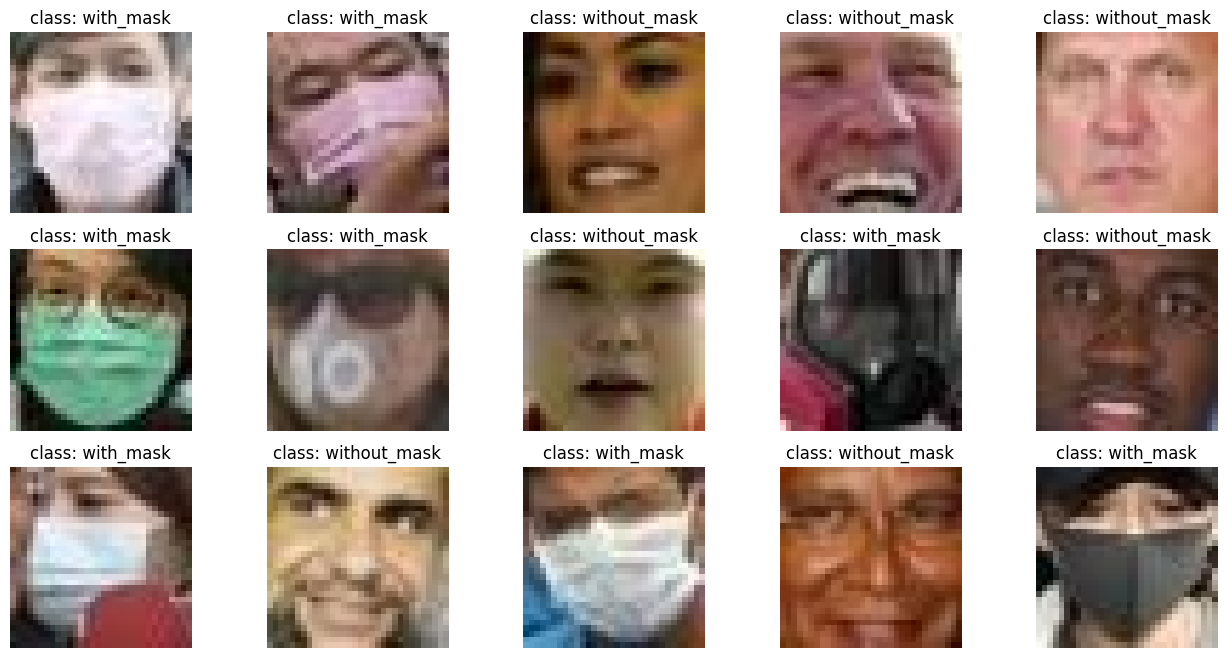

In [ ]:
# Display same images, but with the augmentations
display_random_images(train_data,
                      n=15,
                      classes=class_names,
                      seed=RANDOM_SEED,
                      display_shape=False)

### Train/validation, test functions and plots

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device, dtype=torch.float)

        # 1. Forward pass
        y_pred = model(X).squeeze() # logits

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y) # Using nn.BCEWithLogitsLoss works with raw logits
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.round(torch.sigmoid(y_pred)) # turn logits -> pred probs -> pred labls
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device, dtype=torch.float)

            # 1. Forward pass
            val_pred_logits = model(X).squeeze()

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = torch.round(torch.sigmoid(val_pred_logits)) # turn logits -> pred probs -> pred labls
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [ ]:
def checkpoint(model: torch.nn.Module, filename: str):
    torch.save(model.state_dict(), filename)

def resume(model: torch.nn.Module, filename: str):
    model.load_state_dict(torch.load(filename))

In [ ]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          patience: int,
          scheduler: lr_scheduler,
          best_model_path: str):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
               }

    # Initialize to unusual values
    best_loss = 1000
    best_epoch = -1

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)

        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn)

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # lr of this epoch
        last_lr = scheduler.get_last_lr()

        # Early Stopping and Checkpoints
        if val_loss < best_loss:
          best_loss = val_loss
          best_epoch = epoch
          checkpoint(model, best_model_path)
        elif epoch - best_epoch > patience:
          print("Early stopping at epoch ", epoch)
          break # terminate the training loop

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}| "
            f"lr: {last_lr}"
        )

        # Update the learning rate at the end of each epoch
        scheduler.step()

    # Restore best model
    resume(model, best_model_path)
    print("Resoring best model from epoch", best_epoch+1)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
def test(model: torch.nn.Module,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module):

    # Create empty results dictionary
    results = {"test_loss": [],
               "test_acc": []
               }

    test_loss, test_acc = eval_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"test_loss: {test_loss:.4f} | "f"test_acc: {test_acc:.4f}")

    # Update results dictionary
    results["test_loss"] = test_loss
    results["test_acc"] = test_acc

    # Return the filled results at the end of the epochs
    return results

In [ ]:
def get_best_results(model: torch.nn.Module,
                     data: str,
                     dataloader: torch.utils.data.DataLoader,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: torch.nn.Module):

    loss_str = data + "_loss"
    acc_str =  data + "_acc"

    # Create empty results dictionary
    results = {loss_str: [],
               acc_str: []
               }

    loss, acc = eval_step(model=model,
                          dataloader=dataloader,
                          loss_fn=loss_fn)

    # Print out what's happening
    print(f" {loss_str}: {loss:.4f} | "f"{acc_str}: {acc:.4f}")

    # Update results dictionary
    results[loss_str] = loss
    results[acc_str] = acc

    # Return the filled results at the end of the epochs
    return results

In [ ]:
def plot_loss_curves(results: dict):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and val)
    loss = results['train_loss']
    test_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and val)
    accuracy = results['train_acc']
    test_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
def make_predictions(model: torch.nn.Module,
                     test_dataloader: torch.utils.data.DataLoader,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: torch.nn.Module):

  # Make predictions with trained model
  y_preds = []
  y_probs = []
  y_labels = []
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
      # Send data and targets to target device
      X, y = X.to(device), y.to(device)
      y_label = y
      # Do the forward pass
      y_logit = model(X).squeeze()
      # Turn predictions from logits -> prediction probabilities -> predictions labels
      y_prob = torch.sigmoid(y_logit)
      y_pred = torch.round(y_prob)
      # Put predictions on CPU for evaluation
      y_preds.append(y_pred.cpu())
      y_probs.append(y_prob.cpu())
      y_labels.append(y_label.cpu())
  # Concatenate list of predictions and probabilities into a tensor
  y_pred_tensor = torch.cat(y_preds)
  y_prob_tensor = torch.cat(y_probs)
  y_label_tensor = torch.cat(y_labels)
  return y_pred_tensor, y_prob_tensor, y_label_tensor

In [ ]:
def confusion_matrix(y_pred_tensor: torch.tensor, y_label_tensor: torch.tensor, class_names: list):
  # Setup confusion matrix instance and compare predictions to targets
  confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
  confmat_tensor = confmat(preds=y_pred_tensor,
                           target=y_label_tensor)

  # Plot the confusion matrix
  fig, ax = plot_confusion_matrix(
      conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
      class_names=class_names, # turn the row and column labels into class names
      figsize=(10, 7)
  );

In [ ]:
train_data.class_to_idx # We consider class without_mask as positive

{'with_mask': 0, 'without_mask': 1}

In [ ]:
# Function that plots the presicion recall curves for the different classes and thresholds
def plot_precision_recall_curves_binary(y_probs: torch.tensor, y_label_tensor: torch.tensor):

  # Create subplots
  plt.figure(figsize=(7, 6))
  y_probs_class = y_probs # Probabilities
  # print(y_probs_class)

  # Compute precision-recall pairs for the current class
  # If we want to make the plots for class without_mask, pos_label = 1
  precision, recall, thresholds = precision_recall_curve(y_label_tensor, y_probs_class)

  # Calculate AUC for Precision-Recall curve
  auc_score = auc(recall, precision)
  plt.plot(recall, precision, label=f'AUC = {auc_score:.4f}', color='blue')

  # Set labels and title
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()

  plt.show()

### Create Model0

In [ ]:
# Create a convolutional neural network
class ModelV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, name: str = "ModelV0"):
        super().__init__()
        self.name = name  # Assigning the name attribute
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=6*6*32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        # x = self.conv_block(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        return self.classifier(self.conv_block(x))

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV0(input_shape=img_Channels, output_shape=1).to(device)

In [ ]:
# This is in order to see if all the dimensions inside themodel are correct
input_tensor = torch.randn((1, img_Channels, img_Width, img_Height)) # Adjust the dimensions as needed
# Perform a test  forward pass
output = model(input_tensor.to(device))

In [ ]:
summary(model, input_size=[BATCH_SIZE, img_Channels, img_Width, img_Height]) # test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
ModelV0                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 32, 6, 6]            --
│    └─Conv2d: 2-1                       [32, 16, 30, 30]          448
│    └─ReLU: 2-2                         [32, 16, 30, 30]          --
│    └─MaxPool2d: 2-3                    [32, 16, 15, 15]          --
│    └─Conv2d: 2-4                       [32, 32, 13, 13]          4,640
│    └─ReLU: 2-5                         [32, 32, 13, 13]          --
│    └─MaxPool2d: 2-6                    [32, 32, 6, 6]            --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Flatten: 2-7                      [32, 1152]                --
│    └─Linear: 2-8                       [32, 32]                  36,896
│    └─ReLU: 2-9                         [32, 32]                  --
│    └─Linear: 2-10                      [32, 1]                   33
Total p

#### Train and Evaluate Model0 (without data augmentations)



In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model_0 = ModelV0(input_shape=img_Channels, output_shape=1, name = "model_0_without_augmentations").to(device)

In [ ]:
# Tune hyperparameters
NUM_EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 0.001

# Loss function for binary classification
# torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
# torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in. This means we can use loss with raw logits

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_0_results = train(model=model_0,
                        train_dataloader=original_train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        patience=PATIENCE,
                        scheduler = scheduler,
                        best_model_path="model_0.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5411 | train_acc: 0.7997 | val_loss: 0.2252 | val_acc: 0.9554| lr: [0.001]
Epoch: 2 | train_loss: 0.1788 | train_acc: 0.9484 | val_loss: 0.2235 | val_acc: 0.9263| lr: [0.001]
Epoch: 3 | train_loss: 0.1332 | train_acc: 0.9578 | val_loss: 0.1099 | val_acc: 0.9621| lr: [0.001]
Epoch: 4 | train_loss: 0.1133 | train_acc: 0.9688 | val_loss: 0.0953 | val_acc: 0.9688| lr: [0.001]
Epoch: 5 | train_loss: 0.1088 | train_acc: 0.9688 | val_loss: 0.0843 | val_acc: 0.9732| lr: [0.001]
Epoch: 6 | train_loss: 0.0926 | train_acc: 0.9734 | val_loss: 0.0840 | val_acc: 0.9732| lr: [0.0005]
Epoch: 7 | train_loss: 0.0892 | train_acc: 0.9734 | val_loss: 0.1024 | val_acc: 0.9732| lr: [0.0005]
Epoch: 8 | train_loss: 0.0892 | train_acc: 0.9693 | val_loss: 0.0760 | val_acc: 0.9777| lr: [0.0005]
Epoch: 9 | train_loss: 0.0820 | train_acc: 0.9742 | val_loss: 0.0793 | val_acc: 0.9732| lr: [0.0005]
Epoch: 10 | train_loss: 0.0794 | train_acc: 0.9781 | val_loss: 0.0895 | val_acc: 0.9710| lr: [0.

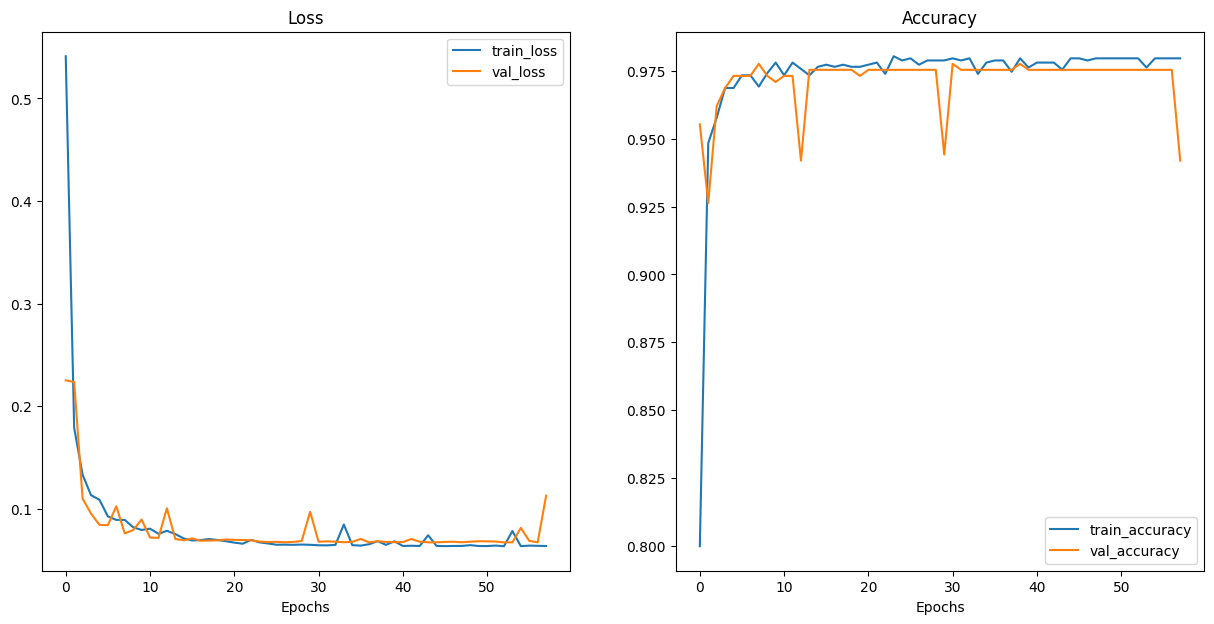

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
# Train best results
model_0_train_results = get_best_results(model=model_0,
                                         data = "train",
                                         dataloader=original_train_dataloader,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn)

# Val best results
model_0_val_results = get_best_results(model=model_0,
                                         data = "val",
                                         dataloader=val_dataloader,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn)

 train_loss: 0.0648 | train_acc: 0.9789
 val_loss: 0.0674 | val_acc: 0.9754


In [ ]:
# Calculate model 0 results on test dataset
model_0_final_results_without_augmentations = {"model_name": model_0.name,
                                               "train_loss": model_0_train_results["train_loss"],
                                               "train_acc": model_0_train_results["train_acc"],
                                               "val_loss": model_0_val_results["val_loss"],
                                               "val_acc": model_0_val_results["val_acc"]}

model_0_final_results_without_augmentations

{'model_name': 'model_0_without_augmentations',
 'train_loss': 0.06481933803297579,
 'train_acc': 0.97890625,
 'val_loss': 0.06738182300302599,
 'val_acc': 0.9754464285714286}

#### Train and Evaluate Model0 (with data augmentations)


In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV0(input_shape=img_Channels, output_shape=1, name = "model_0_with_augmentations").to(device)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_1.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5424 | train_acc: 0.8099 | val_loss: 0.2221 | val_acc: 0.9531| lr: [0.001]
Epoch: 2 | train_loss: 0.1786 | train_acc: 0.9453 | val_loss: 0.2252 | val_acc: 0.9308| lr: [0.001]
Epoch: 3 | train_loss: 0.1343 | train_acc: 0.9594 | val_loss: 0.1095 | val_acc: 0.9643| lr: [0.001]
Epoch: 4 | train_loss: 0.1180 | train_acc: 0.9648 | val_loss: 0.0937 | val_acc: 0.9643| lr: [0.001]
Epoch: 5 | train_loss: 0.1169 | train_acc: 0.9646 | val_loss: 0.0846 | val_acc: 0.9688| lr: [0.001]
Epoch: 6 | train_loss: 0.0959 | train_acc: 0.9719 | val_loss: 0.0824 | val_acc: 0.9688| lr: [0.0005]
Epoch: 7 | train_loss: 0.0916 | train_acc: 0.9719 | val_loss: 0.1072 | val_acc: 0.9732| lr: [0.0005]
Epoch: 8 | train_loss: 0.0907 | train_acc: 0.9701 | val_loss: 0.0755 | val_acc: 0.9732| lr: [0.0005]
Epoch: 9 | train_loss: 0.0846 | train_acc: 0.9734 | val_loss: 0.0767 | val_acc: 0.9710| lr: [0.0005]
Epoch: 10 | train_loss: 0.0829 | train_acc: 0.9758 | val_loss: 0.0872 | val_acc: 0.9754| lr: [0.

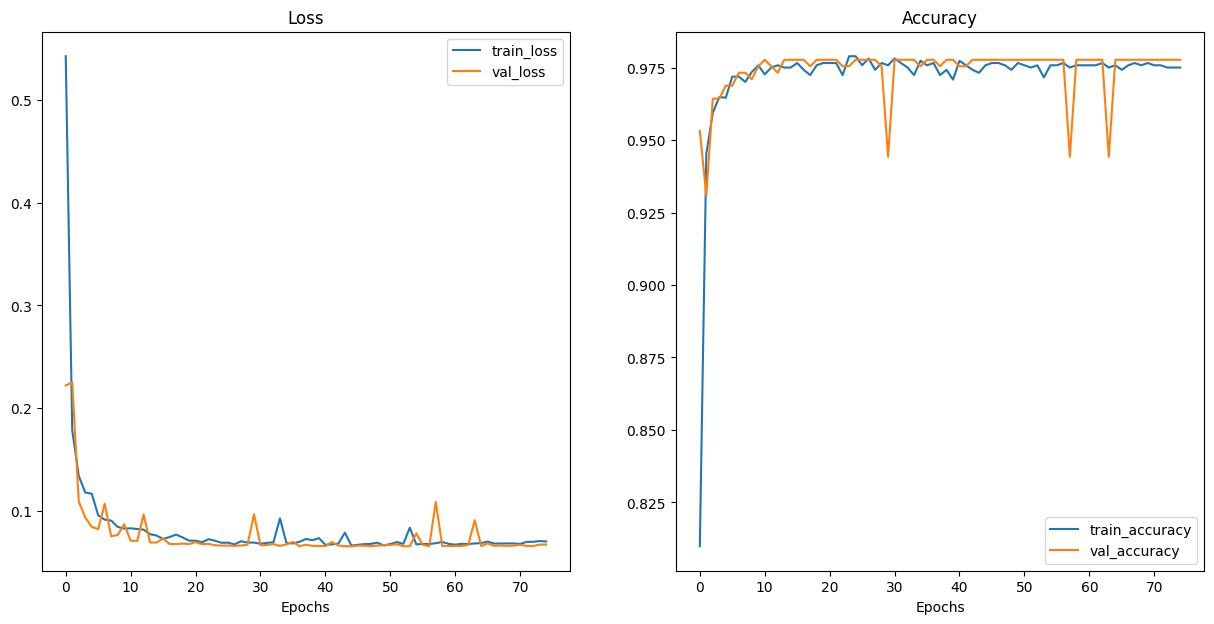

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                         data = "train",
                                         dataloader=train_dataloader,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0675 | train_acc: 0.9766
 val_loss: 0.0662 | val_acc: 0.9777


In [ ]:
# Calculate model 0 results on test dataset
model_0_final_results = {"model_name": model.name,
                         "train_loss": model_train_results["train_loss"],
                         "train_acc": model_train_results["train_acc"],
                         "val_loss": model_val_results["val_loss"],
                         "val_acc": model_val_results["val_acc"]}

model_0_final_results

{'model_name': 'model_0_with_augmentations',
 'train_loss': 0.0675471116323024,
 'train_acc': 0.9765625,
 'val_loss': 0.06619986296365303,
 'val_acc': 0.9776785714285714}

### Create Model1
Add batch normalization layers

In [ ]:
# Create a convolutional neural network
class ModelV1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, name: str = "ModelV1"):
        super().__init__()
        self.name = name  # Assigning the name attribute
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=6*6*32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        # x = self.conv_block(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        return self.classifier(self.conv_block(x))

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV1(input_shape=img_Channels, output_shape=1).to(device)

In [ ]:
# This is in order to see if all the dimensions inside themodel are correct
input_tensor = torch.randn((1, img_Channels, img_Width, img_Height)) # Adjust the dimensions as needed
# Perform a test  forward pass
output = model(input_tensor.to(device))

In [ ]:
summary(model, input_size=[BATCH_SIZE, img_Channels, img_Width, img_Height]) # test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
ModelV1                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 32, 6, 6]            --
│    └─Conv2d: 2-1                       [32, 16, 30, 30]          448
│    └─BatchNorm2d: 2-2                  [32, 16, 30, 30]          32
│    └─ReLU: 2-3                         [32, 16, 30, 30]          --
│    └─MaxPool2d: 2-4                    [32, 16, 15, 15]          --
│    └─Conv2d: 2-5                       [32, 32, 13, 13]          4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 13, 13]          64
│    └─ReLU: 2-7                         [32, 32, 13, 13]          --
│    └─MaxPool2d: 2-8                    [32, 32, 6, 6]            --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Flatten: 2-9                      [32, 1152]                --
│    └─Linear: 2-10                      [32, 32]                  36,896
│    └─

#### Train and Evaluate Model1 (without data augmentations)



In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV1(input_shape=img_Channels, output_shape=1, name = "model_1_without_augmentations").to(device)

In [ ]:
# Tune hyperparameters
NUM_EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 0.00075

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=original_train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_2.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2341 | train_acc: 0.9326 | val_loss: 0.2024 | val_acc: 0.9174| lr: [0.00075]
Epoch: 2 | train_loss: 0.0919 | train_acc: 0.9672 | val_loss: 0.0768 | val_acc: 0.9821| lr: [0.00075]
Epoch: 3 | train_loss: 0.0509 | train_acc: 0.9828 | val_loss: 0.0358 | val_acc: 0.9866| lr: [0.00075]
Epoch: 4 | train_loss: 0.0354 | train_acc: 0.9859 | val_loss: 0.0400 | val_acc: 0.9777| lr: [0.00075]
Epoch: 5 | train_loss: 0.0272 | train_acc: 0.9914 | val_loss: 0.0375 | val_acc: 0.9844| lr: [0.00075]
Epoch: 6 | train_loss: 0.0233 | train_acc: 0.9906 | val_loss: 0.0275 | val_acc: 0.9911| lr: [0.000375]
Epoch: 7 | train_loss: 0.0185 | train_acc: 0.9953 | val_loss: 0.0378 | val_acc: 0.9911| lr: [0.000375]
Epoch: 8 | train_loss: 0.0152 | train_acc: 0.9984 | val_loss: 0.0264 | val_acc: 0.9888| lr: [0.000375]
Epoch: 9 | train_loss: 0.0112 | train_acc: 1.0000 | val_loss: 0.0324 | val_acc: 0.9888| lr: [0.000375]
Epoch: 10 | train_loss: 0.0107 | train_acc: 0.9984 | val_loss: 0.0272 | val_ac

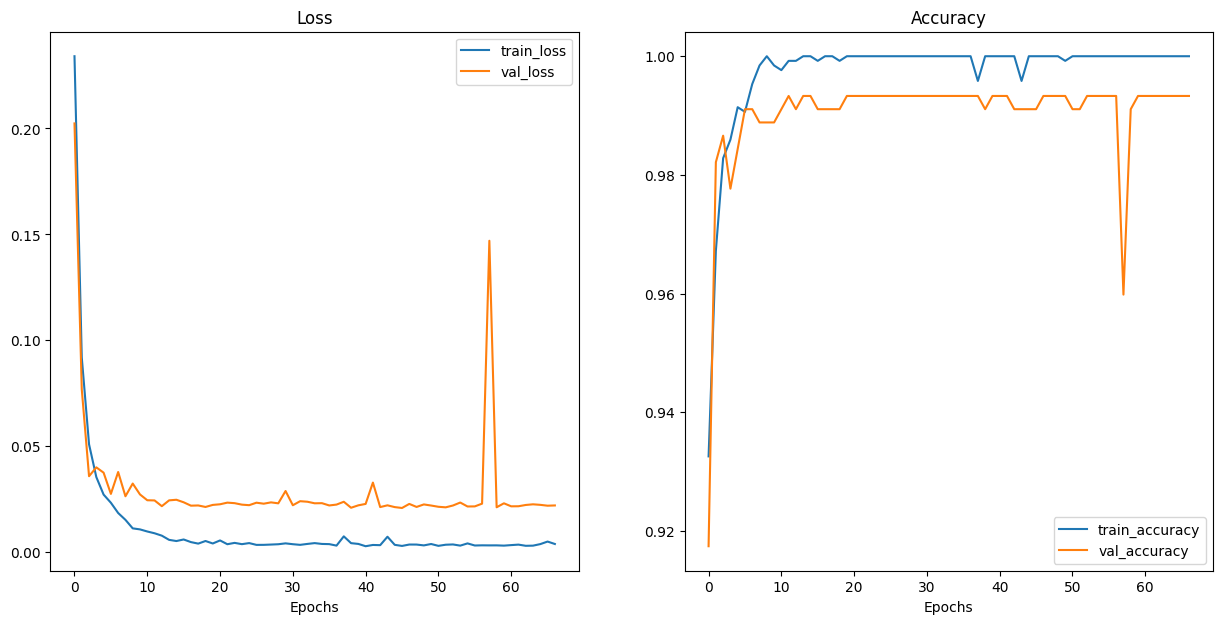

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=original_train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0031 | train_acc: 1.0000
 val_loss: 0.0209 | val_acc: 0.9911


In [ ]:
# Calculate model 1 results on test dataset
model_1_final_results_without_augmentations = {"model_name": model.name,
                                               "train_loss": model_train_results["train_loss"],
                                               "train_acc": model_train_results["train_acc"],
                                               "val_loss": model_val_results["val_loss"],
                                               "val_acc": model_val_results["val_acc"]}

model_1_final_results_without_augmentations

{'model_name': 'model_1_without_augmentations',
 'train_loss': 0.003091694389877375,
 'train_acc': 1.0,
 'val_loss': 0.02086593267657528,
 'val_acc': 0.9910714285714286}

#### Train and Evaluate Model1 (with data augmentations)


In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV1(input_shape=img_Channels, output_shape=1, name = "model_1_with_augmentations").to(device)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_3.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2395 | train_acc: 0.9286 | val_loss: 0.1961 | val_acc: 0.9219| lr: [0.00075]
Epoch: 2 | train_loss: 0.0988 | train_acc: 0.9680 | val_loss: 0.0889 | val_acc: 0.9777| lr: [0.00075]
Epoch: 3 | train_loss: 0.0577 | train_acc: 0.9797 | val_loss: 0.0417 | val_acc: 0.9844| lr: [0.00075]
Epoch: 4 | train_loss: 0.0432 | train_acc: 0.9844 | val_loss: 0.0744 | val_acc: 0.9754| lr: [0.00075]
Epoch: 5 | train_loss: 0.0382 | train_acc: 0.9883 | val_loss: 0.0374 | val_acc: 0.9821| lr: [0.00075]
Epoch: 6 | train_loss: 0.0366 | train_acc: 0.9875 | val_loss: 0.0335 | val_acc: 0.9844| lr: [0.000375]
Epoch: 7 | train_loss: 0.0288 | train_acc: 0.9906 | val_loss: 0.0540 | val_acc: 0.9911| lr: [0.000375]
Epoch: 8 | train_loss: 0.0270 | train_acc: 0.9922 | val_loss: 0.0321 | val_acc: 0.9866| lr: [0.000375]
Epoch: 9 | train_loss: 0.0204 | train_acc: 0.9930 | val_loss: 0.0388 | val_acc: 0.9888| lr: [0.000375]
Epoch: 10 | train_loss: 0.0231 | train_acc: 0.9922 | val_loss: 0.0405 | val_ac

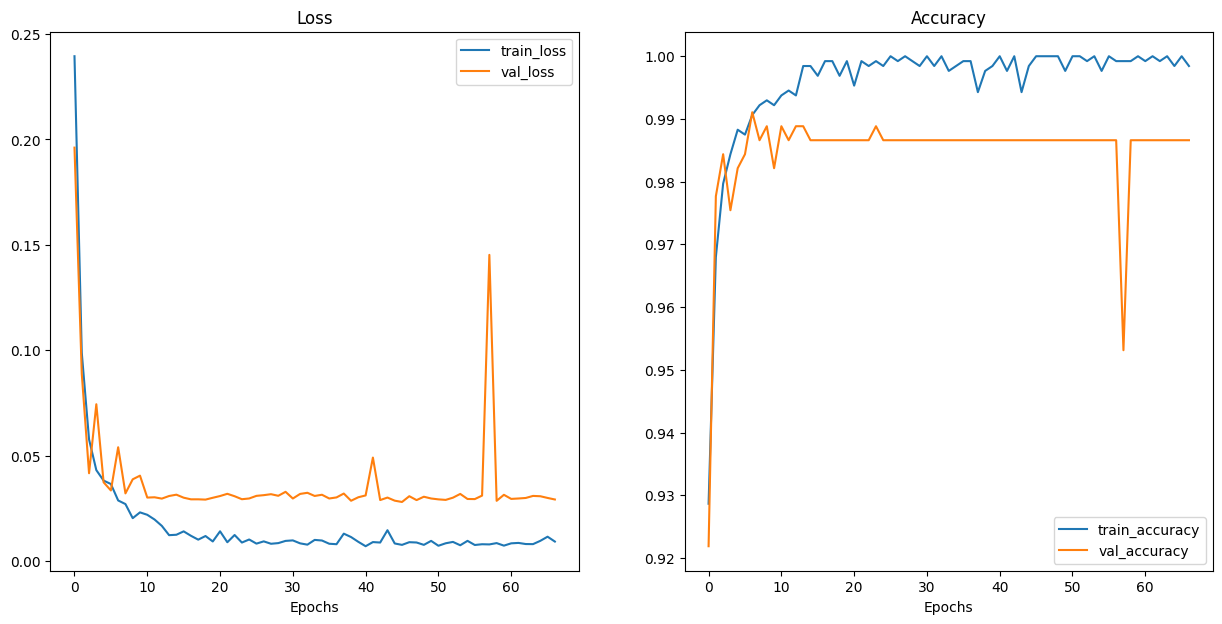

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0078 | train_acc: 1.0000
 val_loss: 0.0281 | val_acc: 0.9866


In [ ]:
# Calculate model 1 results on test dataset
model_1_final_results = {"model_name": model.name,
                         "train_loss": model_train_results["train_loss"],
                         "train_acc": model_train_results["train_acc"],
                         "val_loss": model_val_results["val_loss"],
                         "val_acc": model_val_results["val_acc"]}

model_1_final_results

{'model_name': 'model_1_with_augmentations',
 'train_loss': 0.007814904663246126,
 'train_acc': 1.0,
 'val_loss': 0.0281297140463721,
 'val_acc': 0.9866071428571429}

### Create Model2
kernel_size = 5

In [ ]:
# Create a convolutional neural network
class ModelV2(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, name: str = "ModelV2"):
        super().__init__()
        self.name = name  # Assigning the name attribute
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=5*5*32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        # x = self.conv_block(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        return self.classifier(self.conv_block(x))

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV2(input_shape=img_Channels, output_shape=1).to(device)

In [ ]:
# This is in order to see if all the dimensions inside themodel are correct
input_tensor = torch.randn((1, img_Channels, img_Width, img_Height)) # Adjust the dimensions as needed
# Perform a test  forward pass
output = model(input_tensor.to(device))

In [ ]:
summary(model, input_size=[BATCH_SIZE, img_Channels, img_Width, img_Height]) # test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
ModelV2                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-1                       [32, 16, 28, 28]          1,216
│    └─BatchNorm2d: 2-2                  [32, 16, 28, 28]          32
│    └─ReLU: 2-3                         [32, 16, 28, 28]          --
│    └─MaxPool2d: 2-4                    [32, 16, 14, 14]          --
│    └─Conv2d: 2-5                       [32, 32, 10, 10]          12,832
│    └─BatchNorm2d: 2-6                  [32, 32, 10, 10]          64
│    └─ReLU: 2-7                         [32, 32, 10, 10]          --
│    └─MaxPool2d: 2-8                    [32, 32, 5, 5]            --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Flatten: 2-9                      [32, 800]                 --
│    └─Linear: 2-10                      [32, 32]                  25,632
│   

#### Train and Evaluate Model2 (without data augmentations)



In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV2(input_shape=img_Channels, output_shape=1, name = "model_2_without_augmentations").to(device)

In [ ]:
# Tune hyperparameters
NUM_EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 0.001

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=original_train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_4.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1786 | train_acc: 0.9375 | val_loss: 0.1931 | val_acc: 0.8884| lr: [0.001]
Epoch: 2 | train_loss: 0.0617 | train_acc: 0.9797 | val_loss: 0.0487 | val_acc: 0.9844| lr: [0.001]
Epoch: 3 | train_loss: 0.0439 | train_acc: 0.9844 | val_loss: 0.0339 | val_acc: 0.9888| lr: [0.001]
Epoch: 4 | train_loss: 0.0402 | train_acc: 0.9891 | val_loss: 0.1024 | val_acc: 0.9621| lr: [0.001]
Epoch: 5 | train_loss: 0.0369 | train_acc: 0.9867 | val_loss: 0.0562 | val_acc: 0.9821| lr: [0.001]
Epoch: 6 | train_loss: 0.0132 | train_acc: 0.9977 | val_loss: 0.0244 | val_acc: 0.9888| lr: [0.0005]
Epoch: 7 | train_loss: 0.0091 | train_acc: 0.9984 | val_loss: 0.0261 | val_acc: 0.9911| lr: [0.0005]
Epoch: 8 | train_loss: 0.0090 | train_acc: 0.9969 | val_loss: 0.0278 | val_acc: 0.9911| lr: [0.0005]
Epoch: 9 | train_loss: 0.0064 | train_acc: 0.9992 | val_loss: 0.0283 | val_acc: 0.9866| lr: [0.0005]
Epoch: 10 | train_loss: 0.0046 | train_acc: 0.9992 | val_loss: 0.0224 | val_acc: 0.9933| lr: [0.

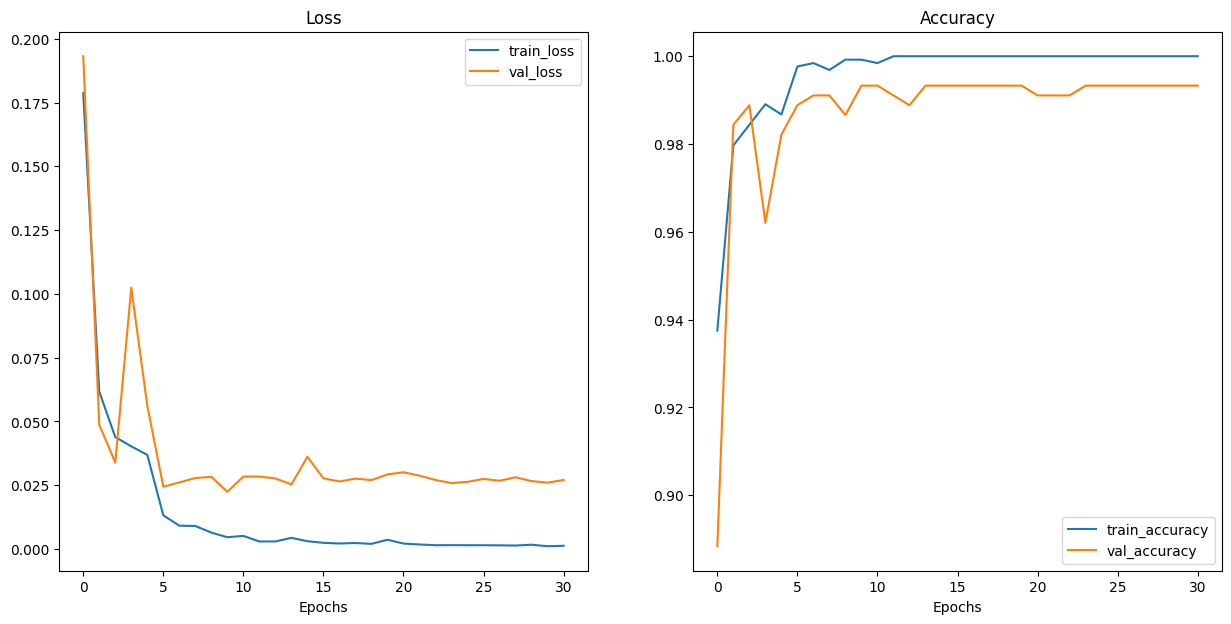

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=original_train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0040 | train_acc: 1.0000
 val_loss: 0.0225 | val_acc: 0.9933


In [ ]:
# Calculate model 2 results on test dataset
model_2_final_results_without_augmentations = {"model_name": model.name,
                                               "train_loss": model_train_results["train_loss"],
                                               "train_acc": model_train_results["train_acc"],
                                               "val_loss": model_val_results["val_loss"],
                                               "val_acc": model_val_results["val_acc"]}

model_2_final_results_without_augmentations

{'model_name': 'model_2_without_augmentations',
 'train_loss': 0.004049972653592704,
 'train_acc': 1.0,
 'val_loss': 0.022450674083562,
 'val_acc': 0.9933035714285714}

#### Train and Evaluate Model2 (with data augmentations)


In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV2(input_shape=img_Channels, output_shape=1, name = "model_2_with_augmentations").to(device)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_5.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1813 | train_acc: 0.9359 | val_loss: 0.1718 | val_acc: 0.9018| lr: [0.001]
Epoch: 2 | train_loss: 0.0672 | train_acc: 0.9789 | val_loss: 0.0439 | val_acc: 0.9844| lr: [0.001]
Epoch: 3 | train_loss: 0.0559 | train_acc: 0.9797 | val_loss: 0.0440 | val_acc: 0.9821| lr: [0.001]
Epoch: 4 | train_loss: 0.0525 | train_acc: 0.9836 | val_loss: 0.0830 | val_acc: 0.9464| lr: [0.001]
Epoch: 5 | train_loss: 0.0456 | train_acc: 0.9828 | val_loss: 0.0410 | val_acc: 0.9844| lr: [0.001]
Epoch: 6 | train_loss: 0.0286 | train_acc: 0.9930 | val_loss: 0.0325 | val_acc: 0.9866| lr: [0.0005]
Epoch: 7 | train_loss: 0.0194 | train_acc: 0.9945 | val_loss: 0.0308 | val_acc: 0.9888| lr: [0.0005]
Epoch: 8 | train_loss: 0.0199 | train_acc: 0.9938 | val_loss: 0.0333 | val_acc: 0.9911| lr: [0.0005]
Epoch: 9 | train_loss: 0.0138 | train_acc: 0.9969 | val_loss: 0.0310 | val_acc: 0.9911| lr: [0.0005]
Epoch: 10 | train_loss: 0.0149 | train_acc: 0.9927 | val_loss: 0.0296 | val_acc: 0.9911| lr: [0.

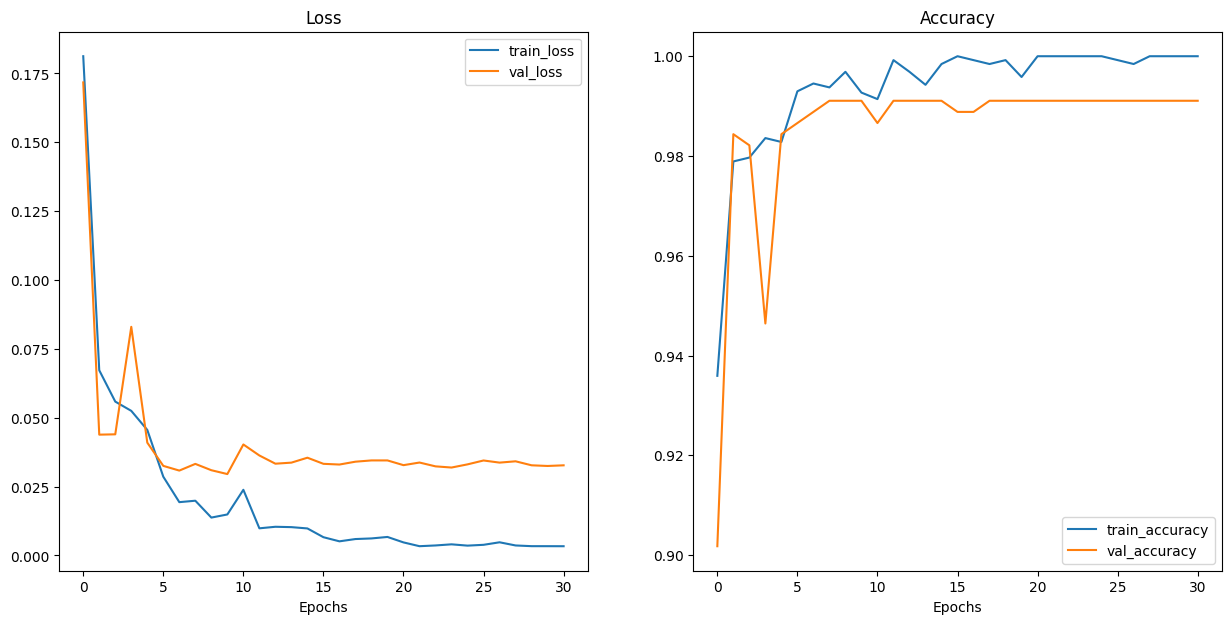

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0183 | train_acc: 0.9938
 val_loss: 0.0298 | val_acc: 0.9911


In [ ]:
# Calculate model 2 results on test dataset
model_2_final_results = {"model_name": model.name,
                         "train_loss": model_train_results["train_loss"],
                         "train_acc": model_train_results["train_acc"],
                         "val_loss": model_val_results["val_loss"],
                         "val_acc": model_val_results["val_acc"]}

model_2_final_results

{'model_name': 'model_2_with_augmentations',
 'train_loss': 0.01828876706713345,
 'train_acc': 0.99375,
 'val_loss': 0.029766354260833135,
 'val_acc': 0.9910714285714286}

### Create Model3
Padding Same

In [ ]:
# Create a convolutional neural network
class ModelV3(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, name: str = "ModelV3"):
        super().__init__()
        self.name = name  # Assigning the name attribute
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=16, kernel_size=3, padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8*32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_shape))

    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        return self.classifier(self.conv_block(x))

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV3(input_shape=img_Channels, output_shape=1).to(device)

In [ ]:
# This is in order to see if all the dimensions inside themodel are correct
input_tensor = torch.randn((1, img_Channels, img_Width, img_Height)) # Adjust the dimensions as needed
# Perform a test  forward pass
output = model(input_tensor.to(device))

In [ ]:
summary(model, input_size=[BATCH_SIZE, img_Channels, img_Width, img_Height]) # test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
ModelV3                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 32, 8, 8]            --
│    └─Conv2d: 2-1                       [32, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [32, 16, 32, 32]          32
│    └─ReLU: 2-3                         [32, 16, 32, 32]          --
│    └─MaxPool2d: 2-4                    [32, 16, 16, 16]          --
│    └─Conv2d: 2-5                       [32, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 16, 16]          64
│    └─ReLU: 2-7                         [32, 32, 16, 16]          --
│    └─MaxPool2d: 2-8                    [32, 32, 8, 8]            --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Flatten: 2-9                      [32, 2048]                --
│    └─Linear: 2-10                      [32, 32]                  65,568
│    └─

#### Train and Evaluate Model3 (without data augmentations)



In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV3(input_shape=img_Channels, output_shape=1, name = "model_3_without_augmentations").to(device)

In [ ]:
# Tune hyperparameters
NUM_EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 0.001

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=original_train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_6.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1737 | train_acc: 0.9344 | val_loss: 0.1332 | val_acc: 0.9710| lr: [0.001]
Epoch: 2 | train_loss: 0.0582 | train_acc: 0.9781 | val_loss: 0.0497 | val_acc: 0.9888| lr: [0.001]
Epoch: 3 | train_loss: 0.0371 | train_acc: 0.9859 | val_loss: 0.0458 | val_acc: 0.9821| lr: [0.001]
Epoch: 4 | train_loss: 0.0340 | train_acc: 0.9883 | val_loss: 0.0442 | val_acc: 0.9844| lr: [0.001]
Epoch: 5 | train_loss: 0.0150 | train_acc: 0.9969 | val_loss: 0.0392 | val_acc: 0.9888| lr: [0.001]
Epoch: 6 | train_loss: 0.0094 | train_acc: 0.9992 | val_loss: 0.0375 | val_acc: 0.9888| lr: [0.0005]
Epoch: 7 | train_loss: 0.0084 | train_acc: 0.9977 | val_loss: 0.0384 | val_acc: 0.9888| lr: [0.0005]
Epoch: 8 | train_loss: 0.0051 | train_acc: 1.0000 | val_loss: 0.0362 | val_acc: 0.9888| lr: [0.0005]
Epoch: 9 | train_loss: 0.0070 | train_acc: 0.9984 | val_loss: 0.0321 | val_acc: 0.9888| lr: [0.0005]
Epoch: 10 | train_loss: 0.0037 | train_acc: 1.0000 | val_loss: 0.0332 | val_acc: 0.9844| lr: [0.

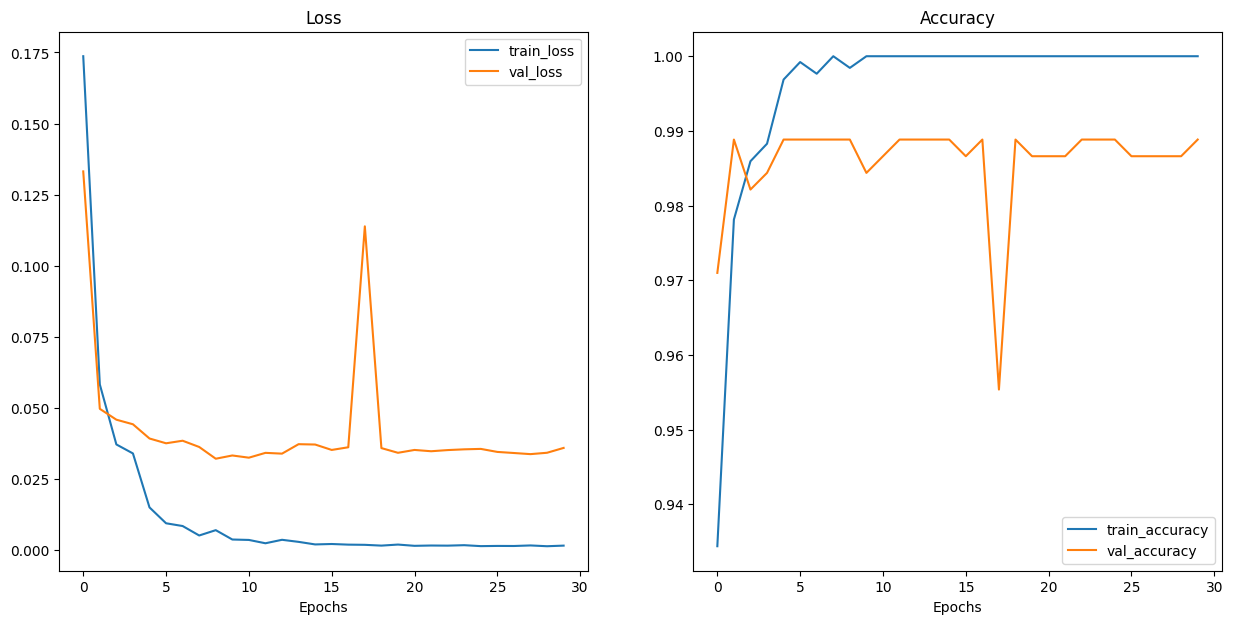

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=original_train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0040 | train_acc: 1.0000
 val_loss: 0.0321 | val_acc: 0.9888


In [ ]:
# Calculate model 3 results on test dataset
model_3_final_results_without_augmentations = {"model_name": model.name,
                                               "train_loss": model_train_results["train_loss"],
                                               "train_acc": model_train_results["train_acc"],
                                               "val_loss": model_val_results["val_loss"],
                                               "val_acc": model_val_results["val_acc"]}

model_3_final_results_without_augmentations

{'model_name': 'model_3_without_augmentations',
 'train_loss': 0.00402239816103247,
 'train_acc': 1.0,
 'val_loss': 0.03213300509794083,
 'val_acc': 0.9888392857142857}

#### Train and Evaluate Model3 (with data augmentations)


In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV3(input_shape=img_Channels, output_shape=1, name = "model_3_with_augmentations").to(device)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_7.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1812 | train_acc: 0.9391 | val_loss: 0.1205 | val_acc: 0.9754| lr: [0.001]
Epoch: 2 | train_loss: 0.0624 | train_acc: 0.9789 | val_loss: 0.0509 | val_acc: 0.9866| lr: [0.001]
Epoch: 3 | train_loss: 0.0526 | train_acc: 0.9781 | val_loss: 0.0605 | val_acc: 0.9777| lr: [0.001]
Epoch: 4 | train_loss: 0.0437 | train_acc: 0.9820 | val_loss: 0.0427 | val_acc: 0.9844| lr: [0.001]
Epoch: 5 | train_loss: 0.0309 | train_acc: 0.9930 | val_loss: 0.0515 | val_acc: 0.9866| lr: [0.001]
Epoch: 6 | train_loss: 0.0213 | train_acc: 0.9930 | val_loss: 0.0459 | val_acc: 0.9821| lr: [0.0005]
Epoch: 7 | train_loss: 0.0197 | train_acc: 0.9906 | val_loss: 0.0490 | val_acc: 0.9866| lr: [0.0005]
Epoch: 8 | train_loss: 0.0126 | train_acc: 0.9969 | val_loss: 0.0458 | val_acc: 0.9844| lr: [0.0005]
Epoch: 9 | train_loss: 0.0142 | train_acc: 0.9945 | val_loss: 0.0458 | val_acc: 0.9866| lr: [0.0005]
Epoch: 10 | train_loss: 0.0100 | train_acc: 0.9977 | val_loss: 0.0477 | val_acc: 0.9866| lr: [0.

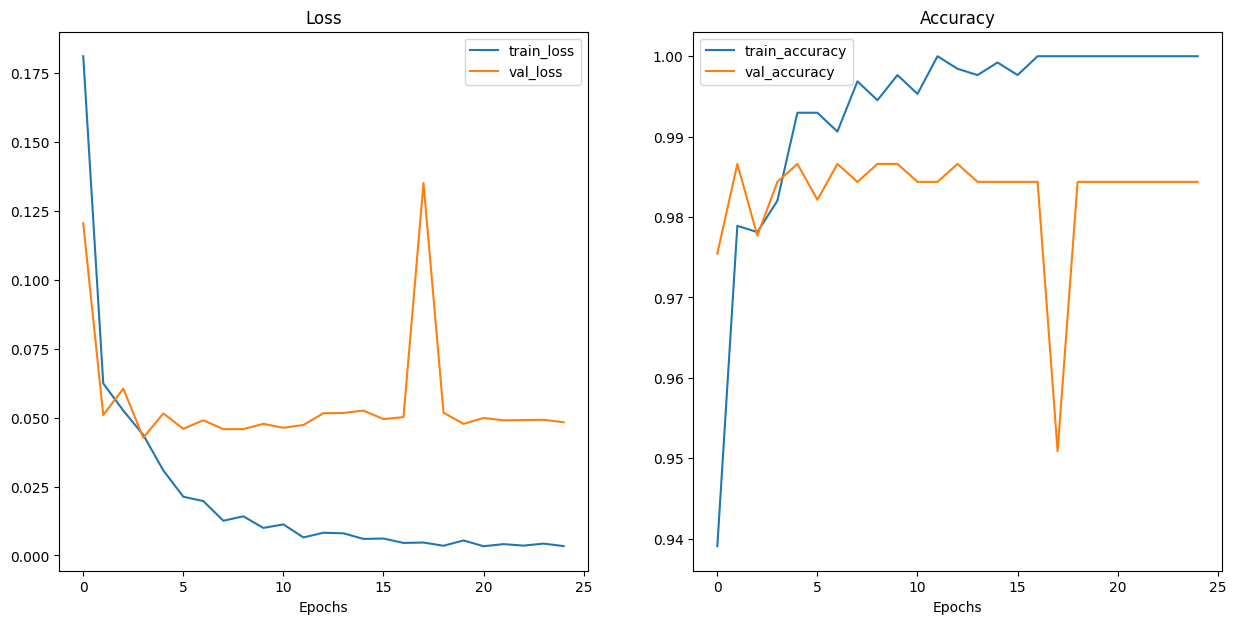

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0295 | train_acc: 0.9914
 val_loss: 0.0428 | val_acc: 0.9844


In [ ]:
# Calculate model 3 results on test dataset
model_3_final_results = {"model_name": model.name,
                         "train_loss": model_train_results["train_loss"],
                         "train_acc": model_train_results["train_acc"],
                         "val_loss": model_val_results["val_loss"],
                         "val_acc": model_val_results["val_acc"]}

model_3_final_results

{'model_name': 'model_3_with_augmentations',
 'train_loss': 0.029468713930691594,
 'train_acc': 0.99140625,
 'val_loss': 0.04277529994890626,
 'val_acc': 0.984375}

### Create Model4
Padding Same, kernel_size=5

In [ ]:
# Create a convolutional neural network
class ModelV4(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, name: str = "ModelV4"):
        super().__init__()
        self.name = name  # Assigning the name attribute
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=16, kernel_size=5, padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8*32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_shape))

    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        return self.classifier(self.conv_block(x))

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV4(input_shape=img_Channels, output_shape=1).to(device)

In [ ]:
# This is in order to see if all the dimensions inside themodel are correct
input_tensor = torch.randn((1, img_Channels, img_Width, img_Height)) # Adjust the dimensions as needed
# Perform a test  forward pass
output = model(input_tensor.to(device))

In [ ]:
summary(model, input_size=[BATCH_SIZE, img_Channels, img_Width, img_Height]) # test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
ModelV4                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 32, 8, 8]            --
│    └─Conv2d: 2-1                       [32, 16, 32, 32]          1,216
│    └─BatchNorm2d: 2-2                  [32, 16, 32, 32]          32
│    └─ReLU: 2-3                         [32, 16, 32, 32]          --
│    └─MaxPool2d: 2-4                    [32, 16, 16, 16]          --
│    └─Conv2d: 2-5                       [32, 32, 16, 16]          12,832
│    └─BatchNorm2d: 2-6                  [32, 32, 16, 16]          64
│    └─ReLU: 2-7                         [32, 32, 16, 16]          --
│    └─MaxPool2d: 2-8                    [32, 32, 8, 8]            --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Flatten: 2-9                      [32, 2048]                --
│    └─Linear: 2-10                      [32, 32]                  65,568
│   

#### Train and Evaluate Model4 (without data augmentations)



In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV4(input_shape=img_Channels, output_shape=1, name = "model_4_without_augmentations").to(device)

In [ ]:
# Tune hyperparameters
NUM_EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 0.001

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=original_train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_8.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1833 | train_acc: 0.9234 | val_loss: 0.1575 | val_acc: 0.9420| lr: [0.001]
Epoch: 2 | train_loss: 0.0903 | train_acc: 0.9701 | val_loss: 0.2938 | val_acc: 0.9018| lr: [0.001]
Epoch: 3 | train_loss: 0.0597 | train_acc: 0.9797 | val_loss: 0.0442 | val_acc: 0.9866| lr: [0.001]
Epoch: 4 | train_loss: 0.0349 | train_acc: 0.9867 | val_loss: 0.0352 | val_acc: 0.9911| lr: [0.001]
Epoch: 5 | train_loss: 0.0280 | train_acc: 0.9891 | val_loss: 0.0333 | val_acc: 0.9911| lr: [0.001]
Epoch: 6 | train_loss: 0.0134 | train_acc: 0.9969 | val_loss: 0.0436 | val_acc: 0.9888| lr: [0.0005]
Epoch: 7 | train_loss: 0.0084 | train_acc: 0.9992 | val_loss: 0.0354 | val_acc: 0.9888| lr: [0.0005]
Epoch: 8 | train_loss: 0.0072 | train_acc: 0.9992 | val_loss: 0.0321 | val_acc: 0.9888| lr: [0.0005]
Epoch: 9 | train_loss: 0.0061 | train_acc: 0.9992 | val_loss: 0.0278 | val_acc: 0.9911| lr: [0.0005]
Epoch: 10 | train_loss: 0.0044 | train_acc: 1.0000 | val_loss: 0.0305 | val_acc: 0.9911| lr: [0.

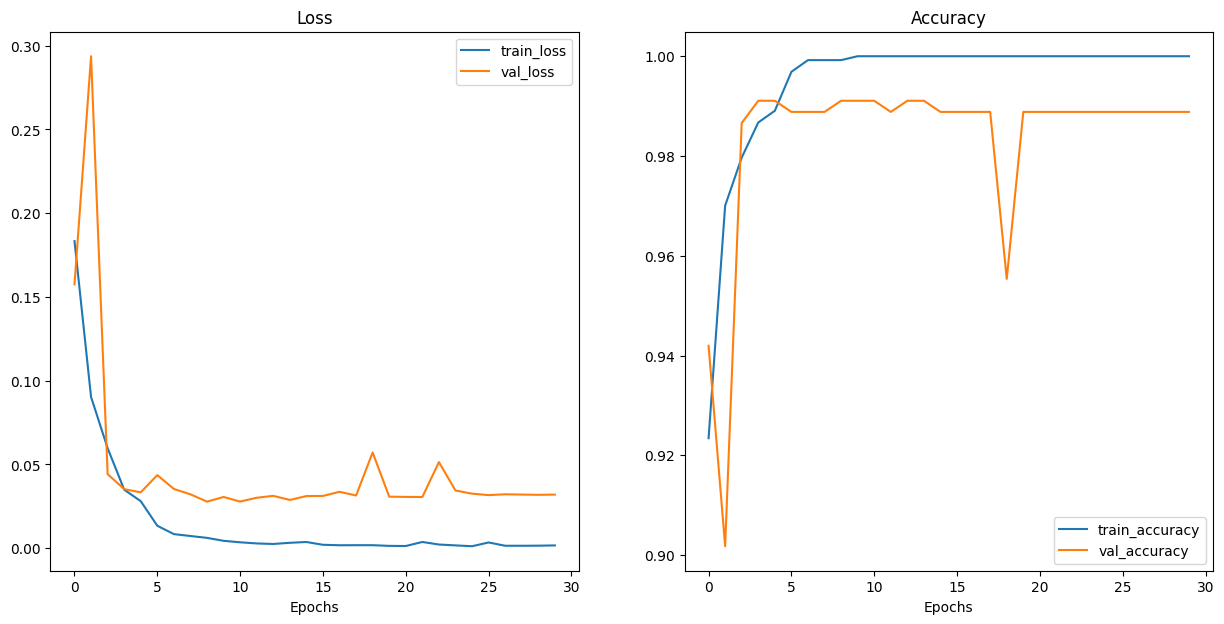

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=original_train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0051 | train_acc: 1.0000
 val_loss: 0.0283 | val_acc: 0.9911


In [ ]:
# Calculate model 4 results on test dataset
model_4_final_results_without_augmentations = {"model_name": model.name,
                                               "train_loss": model_train_results["train_loss"],
                                               "train_acc": model_train_results["train_acc"],
                                               "val_loss": model_val_results["val_loss"],
                                               "val_acc": model_val_results["val_acc"]}

model_4_final_results_without_augmentations

{'model_name': 'model_4_without_augmentations',
 'train_loss': 0.0050970202675671315,
 'train_acc': 1.0,
 'val_loss': 0.028333141335419247,
 'val_acc': 0.9910714285714286}

#### Train and Evaluate Model4 (with data augmentations)


In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV4(input_shape=img_Channels, output_shape=1, name = "model_4_with_augmentations").to(device)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_9.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1978 | train_acc: 0.9201 | val_loss: 0.2129 | val_acc: 0.9219| lr: [0.001]
Epoch: 2 | train_loss: 0.0915 | train_acc: 0.9693 | val_loss: 0.0967 | val_acc: 0.9621| lr: [0.001]
Epoch: 3 | train_loss: 0.0742 | train_acc: 0.9773 | val_loss: 0.0551 | val_acc: 0.9844| lr: [0.001]
Epoch: 4 | train_loss: 0.0444 | train_acc: 0.9828 | val_loss: 0.0391 | val_acc: 0.9866| lr: [0.001]
Epoch: 5 | train_loss: 0.0418 | train_acc: 0.9828 | val_loss: 0.0525 | val_acc: 0.9866| lr: [0.001]
Epoch: 6 | train_loss: 0.0273 | train_acc: 0.9906 | val_loss: 0.0724 | val_acc: 0.9487| lr: [0.0005]
Epoch: 7 | train_loss: 0.0247 | train_acc: 0.9904 | val_loss: 0.0379 | val_acc: 0.9911| lr: [0.0005]
Epoch: 8 | train_loss: 0.0280 | train_acc: 0.9914 | val_loss: 0.0417 | val_acc: 0.9844| lr: [0.0005]
Epoch: 9 | train_loss: 0.0184 | train_acc: 0.9953 | val_loss: 0.0380 | val_acc: 0.9866| lr: [0.0005]
Epoch: 10 | train_loss: 0.0158 | train_acc: 0.9945 | val_loss: 0.0364 | val_acc: 0.9866| lr: [0.

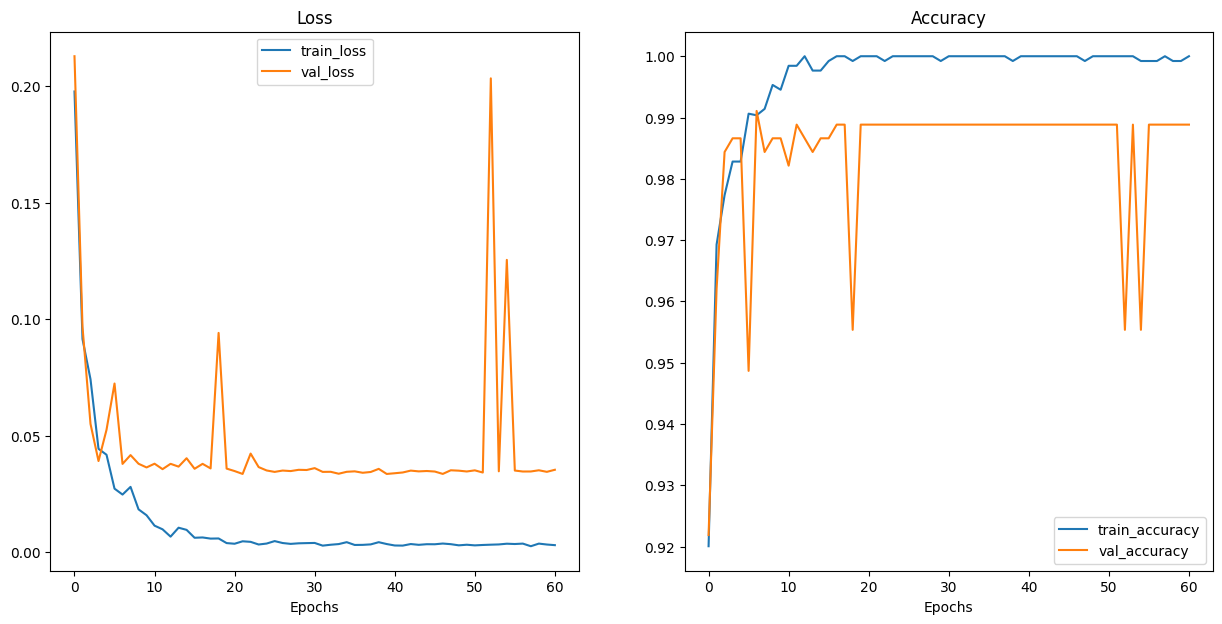

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0031 | train_acc: 1.0000
 val_loss: 0.0336 | val_acc: 0.9888


In [ ]:
# Calculate model 4 results on test dataset
model_4_final_results = {"model_name": model.name,
                         "train_loss": model_train_results["train_loss"],
                         "train_acc": model_train_results["train_acc"],
                         "val_loss": model_val_results["val_loss"],
                         "val_acc": model_val_results["val_acc"]}

model_4_final_results

{'model_name': 'model_4_with_augmentations',
 'train_loss': 0.0030627924905274996,
 'train_acc': 1.0,
 'val_loss': 0.03357333852337823,
 'val_acc': 0.9888392857142857}

### Create Model5
Padding Same, kernel_size=5, more filters, bigger classifier

In [ ]:
# Create a convolutional neural network
class ModelV5(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, name: str = "ModelV5"):
        super().__init__()
        self.name = name  # Assigning the name attribute
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=32, kernel_size=5, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8*64, out_features=64),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block(x))

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV5(input_shape=img_Channels, output_shape=1).to(device)

In [ ]:
# This is in order to see if all the dimensions inside themodel are correct
input_tensor = torch.randn((1, img_Channels, img_Width, img_Height)) # Adjust the dimensions as needed
# Perform a test  forward pass
output = model(input_tensor.to(device))

In [ ]:
summary(model, input_size=[BATCH_SIZE, img_Channels, img_Width, img_Height]) # test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
ModelV5                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 8, 8]            --
│    └─Conv2d: 2-1                       [32, 32, 32, 32]          2,432
│    └─BatchNorm2d: 2-2                  [32, 32, 32, 32]          64
│    └─ReLU: 2-3                         [32, 32, 32, 32]          --
│    └─MaxPool2d: 2-4                    [32, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [32, 64, 16, 16]          51,264
│    └─BatchNorm2d: 2-6                  [32, 64, 16, 16]          128
│    └─ReLU: 2-7                         [32, 64, 16, 16]          --
│    └─MaxPool2d: 2-8                    [32, 64, 8, 8]            --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Flatten: 2-9                      [32, 4096]                --
│    └─Linear: 2-10                      [32, 64]                  262,208
│ 

#### Train and Evaluate Model5 (without data augmentations)



In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV5(input_shape=img_Channels, output_shape=1, name = "model_5_without_augmentations").to(device)

In [ ]:
# Tune hyperparameters
NUM_EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 0.001

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=original_train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_10.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1990 | train_acc: 0.9242 | val_loss: 0.1826 | val_acc: 0.9263| lr: [0.001]
Epoch: 2 | train_loss: 0.0696 | train_acc: 0.9789 | val_loss: 0.0546 | val_acc: 0.9821| lr: [0.001]
Epoch: 3 | train_loss: 0.0565 | train_acc: 0.9797 | val_loss: 0.0538 | val_acc: 0.9799| lr: [0.001]
Epoch: 4 | train_loss: 0.0514 | train_acc: 0.9852 | val_loss: 0.0443 | val_acc: 0.9888| lr: [0.001]
Epoch: 5 | train_loss: 0.0454 | train_acc: 0.9867 | val_loss: 0.0898 | val_acc: 0.9643| lr: [0.001]
Epoch: 6 | train_loss: 0.0188 | train_acc: 0.9930 | val_loss: 0.0489 | val_acc: 0.9821| lr: [0.0005]
Epoch: 7 | train_loss: 0.0119 | train_acc: 0.9961 | val_loss: 0.0316 | val_acc: 0.9933| lr: [0.0005]
Epoch: 8 | train_loss: 0.0082 | train_acc: 0.9977 | val_loss: 0.0383 | val_acc: 0.9911| lr: [0.0005]
Epoch: 9 | train_loss: 0.0095 | train_acc: 0.9961 | val_loss: 0.0363 | val_acc: 0.9911| lr: [0.0005]
Epoch: 10 | train_loss: 0.0072 | train_acc: 0.9969 | val_loss: 0.0521 | val_acc: 0.9866| lr: [0.

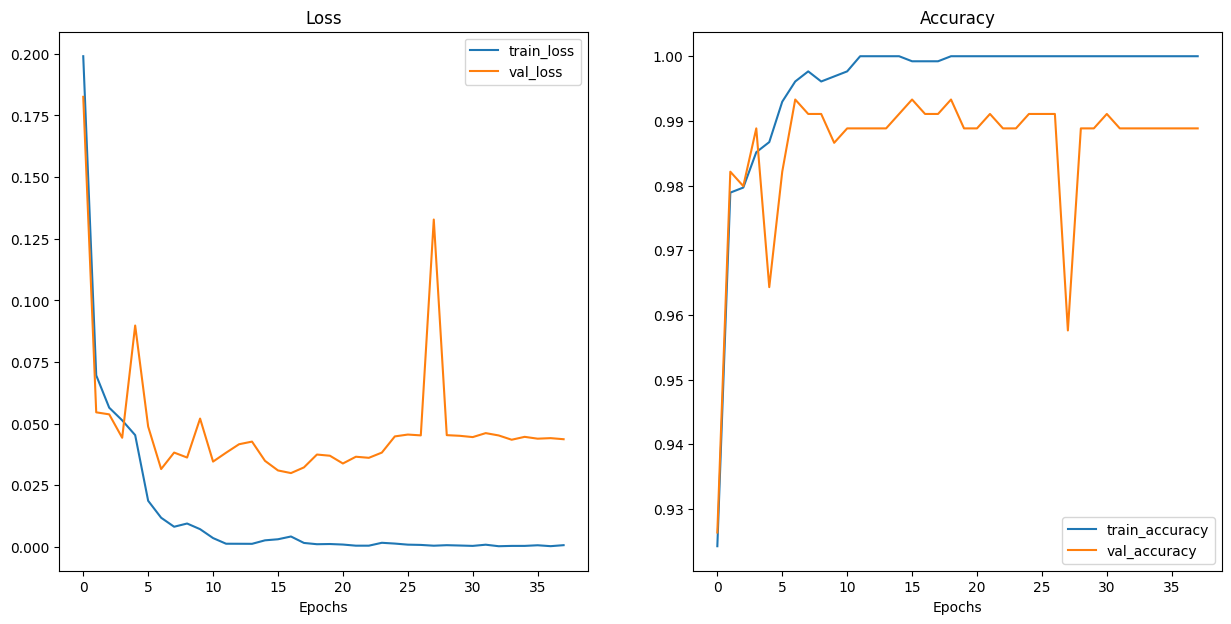

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=original_train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0005 | train_acc: 1.0000
 val_loss: 0.0300 | val_acc: 0.9911


In [ ]:
# Calculate model 5 results on test dataset
model_5_final_results_without_augmentations = {"model_name": model.name,
                                               "train_loss": model_train_results["train_loss"],
                                               "train_acc": model_train_results["train_acc"],
                                               "val_loss": model_val_results["val_loss"],
                                               "val_acc": model_val_results["val_acc"]}

model_5_final_results_without_augmentations

{'model_name': 'model_5_without_augmentations',
 'train_loss': 0.000537072741326483,
 'train_acc': 1.0,
 'val_loss': 0.02998034532278585,
 'val_acc': 0.9910714285714286}

#### Train and Evaluate Model5 (with data augmentations)


In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV5(input_shape=img_Channels, output_shape=1, name = "model_5_with_augmentations").to(device)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_11.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2068 | train_acc: 0.9156 | val_loss: 0.3426 | val_acc: 0.8415| lr: [0.001]
Epoch: 2 | train_loss: 0.0772 | train_acc: 0.9727 | val_loss: 0.0564 | val_acc: 0.9844| lr: [0.001]
Epoch: 3 | train_loss: 0.0746 | train_acc: 0.9797 | val_loss: 0.0617 | val_acc: 0.9821| lr: [0.001]
Epoch: 4 | train_loss: 0.0607 | train_acc: 0.9794 | val_loss: 0.0584 | val_acc: 0.9799| lr: [0.001]
Epoch: 5 | train_loss: 0.0641 | train_acc: 0.9802 | val_loss: 0.0581 | val_acc: 0.9754| lr: [0.001]
Epoch: 6 | train_loss: 0.0408 | train_acc: 0.9852 | val_loss: 0.0267 | val_acc: 0.9911| lr: [0.0005]
Epoch: 7 | train_loss: 0.0329 | train_acc: 0.9867 | val_loss: 0.0274 | val_acc: 0.9911| lr: [0.0005]
Epoch: 8 | train_loss: 0.0291 | train_acc: 0.9883 | val_loss: 0.0322 | val_acc: 0.9911| lr: [0.0005]
Epoch: 9 | train_loss: 0.0226 | train_acc: 0.9898 | val_loss: 0.0280 | val_acc: 0.9933| lr: [0.0005]
Epoch: 10 | train_loss: 0.0273 | train_acc: 0.9875 | val_loss: 0.0263 | val_acc: 0.9888| lr: [0.

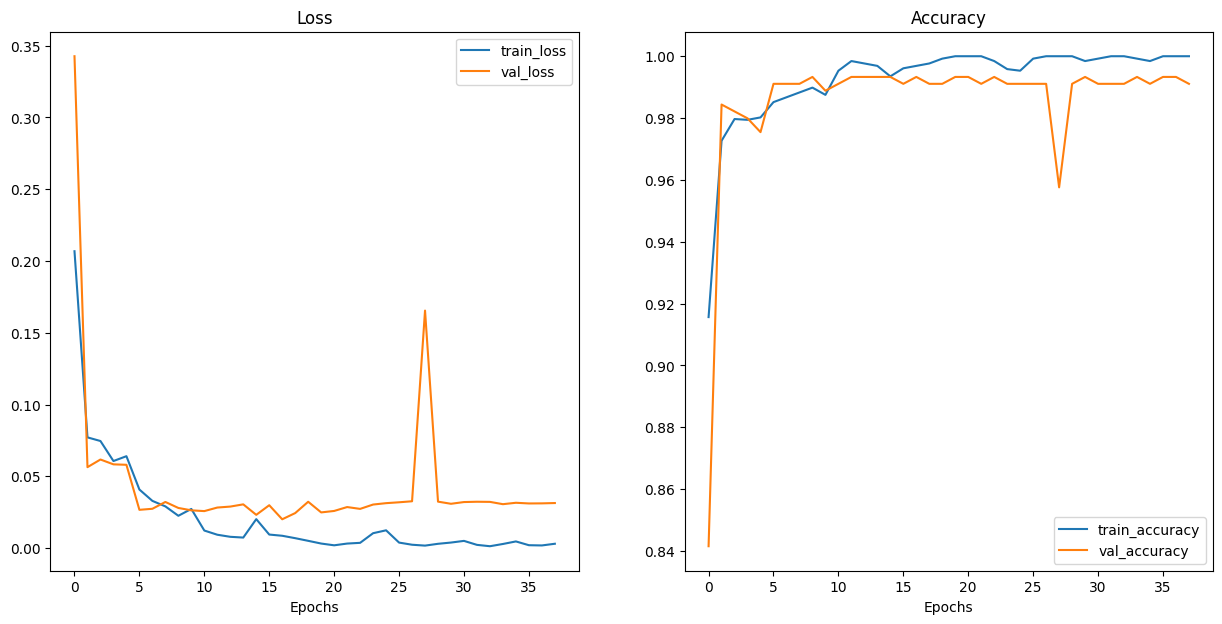

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0058 | train_acc: 0.9977
 val_loss: 0.0201 | val_acc: 0.9933


In [ ]:
# Calculate model 5 results on test dataset
model_5_final_results = {"model_name": model.name,
                         "train_loss": model_train_results["train_loss"],
                         "train_acc": model_train_results["train_acc"],
                         "val_loss": model_val_results["val_loss"],
                         "val_acc": model_val_results["val_acc"]}

model_5_final_results

{'model_name': 'model_5_with_augmentations',
 'train_loss': 0.005807724115038581,
 'train_acc': 0.99765625,
 'val_loss': 0.020119471364263525,
 'val_acc': 0.9933035714285714}

### Create Model6
Padding Same, kernel_size=5, bigger classifier

In [ ]:
# Create a convolutional neural network
class ModelV6(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, name: str = "ModelV6"):
        super().__init__()
        self.name = name  # Assigning the name attribute
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=16, kernel_size=5, padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8*32, out_features=32),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block(x))

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV6(input_shape=img_Channels, output_shape=1).to(device)

In [ ]:
# This is in order to see if all the dimensions inside themodel are correct
input_tensor = torch.randn((1, img_Channels, img_Width, img_Height)) # Adjust the dimensions as needed
# Perform a test  forward pass
output = model(input_tensor.to(device))

In [ ]:
summary(model, input_size=[BATCH_SIZE, img_Channels, img_Width, img_Height]) # test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
ModelV6                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 32, 8, 8]            --
│    └─Conv2d: 2-1                       [32, 16, 32, 32]          1,216
│    └─BatchNorm2d: 2-2                  [32, 16, 32, 32]          32
│    └─ReLU: 2-3                         [32, 16, 32, 32]          --
│    └─MaxPool2d: 2-4                    [32, 16, 16, 16]          --
│    └─Conv2d: 2-5                       [32, 32, 16, 16]          12,832
│    └─BatchNorm2d: 2-6                  [32, 32, 16, 16]          64
│    └─ReLU: 2-7                         [32, 32, 16, 16]          --
│    └─MaxPool2d: 2-8                    [32, 32, 8, 8]            --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Flatten: 2-9                      [32, 2048]                --
│    └─Linear: 2-10                      [32, 32]                  65,568
│   

#### Train and Evaluate Model6 (without data augmentations)



In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV6(input_shape=img_Channels, output_shape=1, name = "model_6_without_augmentations").to(device)

In [ ]:
# Tune hyperparameters
NUM_EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 0.001

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=original_train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_12.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3089 | train_acc: 0.8781 | val_loss: 0.3068 | val_acc: 0.8772| lr: [0.001]
Epoch: 2 | train_loss: 0.1095 | train_acc: 0.9680 | val_loss: 0.0670 | val_acc: 0.9844| lr: [0.001]
Epoch: 3 | train_loss: 0.1013 | train_acc: 0.9701 | val_loss: 0.0727 | val_acc: 0.9754| lr: [0.001]
Epoch: 4 | train_loss: 0.0958 | train_acc: 0.9664 | val_loss: 0.0591 | val_acc: 0.9799| lr: [0.001]
Epoch: 5 | train_loss: 0.0705 | train_acc: 0.9805 | val_loss: 0.0557 | val_acc: 0.9777| lr: [0.001]
Epoch: 6 | train_loss: 0.0374 | train_acc: 0.9891 | val_loss: 0.0467 | val_acc: 0.9821| lr: [0.0005]
Epoch: 7 | train_loss: 0.0370 | train_acc: 0.9852 | val_loss: 0.0403 | val_acc: 0.9799| lr: [0.0005]
Epoch: 8 | train_loss: 0.0288 | train_acc: 0.9891 | val_loss: 0.0435 | val_acc: 0.9888| lr: [0.0005]
Epoch: 9 | train_loss: 0.0192 | train_acc: 0.9938 | val_loss: 0.0590 | val_acc: 0.9821| lr: [0.0005]
Epoch: 10 | train_loss: 0.0264 | train_acc: 0.9914 | val_loss: 0.0451 | val_acc: 0.9821| lr: [0.

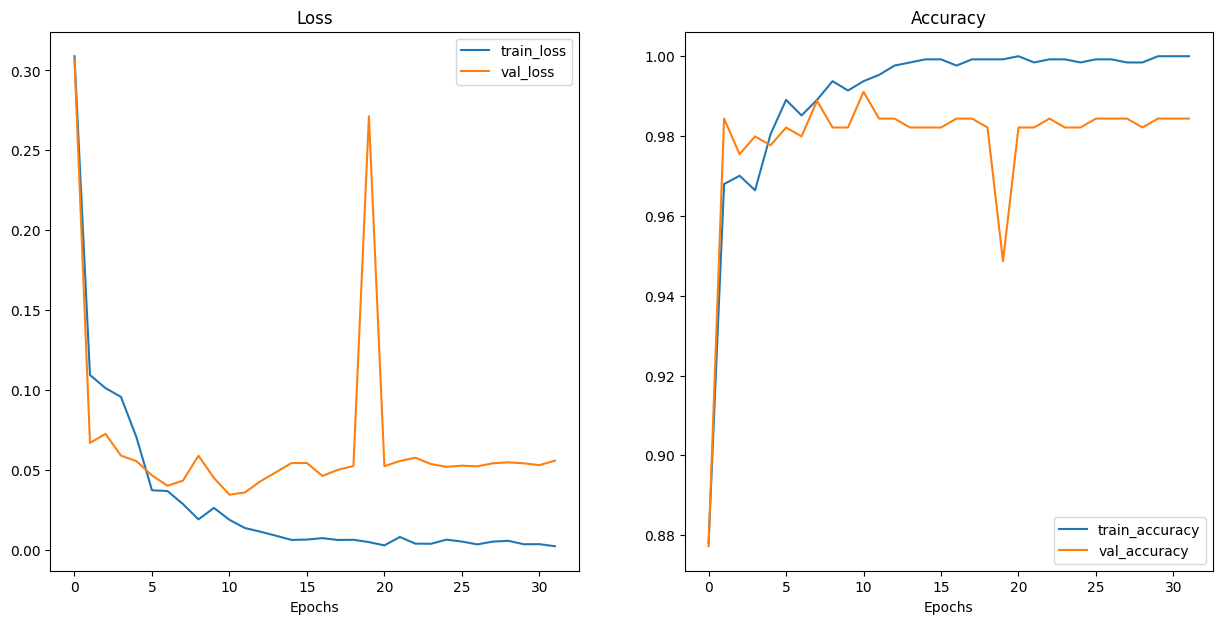

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=original_train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0075 | train_acc: 0.9984
 val_loss: 0.0346 | val_acc: 0.9911


In [ ]:
# Calculate model 5 results on test dataset
model_6_final_results_without_augmentations = {"model_name": model.name,
                                               "train_loss": model_train_results["train_loss"],
                                               "train_acc": model_train_results["train_acc"],
                                               "val_loss": model_val_results["val_loss"],
                                               "val_acc": model_val_results["val_acc"]}

model_6_final_results_without_augmentations

{'model_name': 'model_6_without_augmentations',
 'train_loss': 0.00750947847700445,
 'train_acc': 0.9984375,
 'val_loss': 0.03462790548504862,
 'val_acc': 0.9910714285714286}

#### Train and Evaluate Model6 (with data augmentations)


In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV6(input_shape=img_Channels, output_shape=1, name = "model_6_with_augmentations").to(device)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler = scheduler,
                      best_model_path="model_13.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2730 | train_acc: 0.8953 | val_loss: 0.3288 | val_acc: 0.8482| lr: [0.001]
Epoch: 2 | train_loss: 0.1151 | train_acc: 0.9609 | val_loss: 0.0720 | val_acc: 0.9754| lr: [0.001]
Epoch: 3 | train_loss: 0.1069 | train_acc: 0.9646 | val_loss: 0.0526 | val_acc: 0.9799| lr: [0.001]
Epoch: 4 | train_loss: 0.0915 | train_acc: 0.9672 | val_loss: 0.0454 | val_acc: 0.9821| lr: [0.001]
Epoch: 5 | train_loss: 0.0691 | train_acc: 0.9750 | val_loss: 0.0639 | val_acc: 0.9866| lr: [0.001]
Epoch: 6 | train_loss: 0.0448 | train_acc: 0.9836 | val_loss: 0.0483 | val_acc: 0.9821| lr: [0.0005]
Epoch: 7 | train_loss: 0.0386 | train_acc: 0.9859 | val_loss: 0.0557 | val_acc: 0.9821| lr: [0.0005]
Epoch: 8 | train_loss: 0.0402 | train_acc: 0.9867 | val_loss: 0.0534 | val_acc: 0.9844| lr: [0.0005]
Epoch: 9 | train_loss: 0.0302 | train_acc: 0.9914 | val_loss: 0.0356 | val_acc: 0.9844| lr: [0.0005]
Epoch: 10 | train_loss: 0.0282 | train_acc: 0.9898 | val_loss: 0.0328 | val_acc: 0.9911| lr: [0.

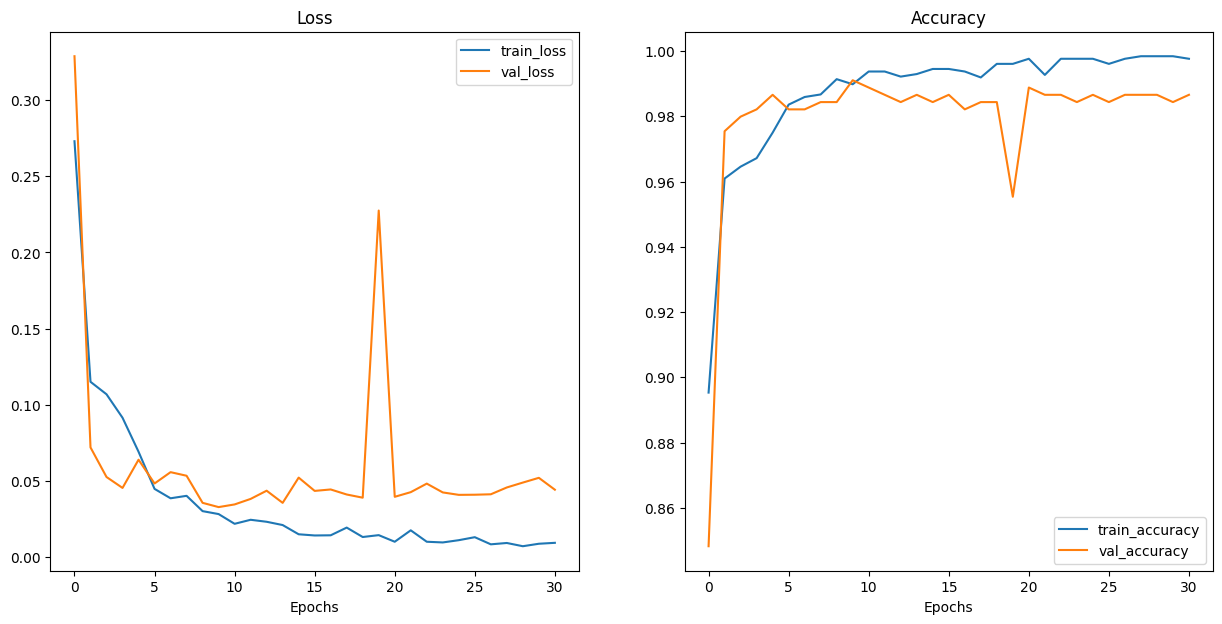

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Train best results
model_train_results = get_best_results(model=model,
                                       data = "train",
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)

# Val best results
model_val_results = get_best_results(model=model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 train_loss: 0.0150 | train_acc: 0.9953
 val_loss: 0.0328 | val_acc: 0.9911


In [ ]:
# Calculate model 5 results on test dataset
model_6_final_results = {"model_name": model.name,
                         "train_loss": model_train_results["train_loss"],
                         "train_acc": model_train_results["train_acc"],
                         "val_loss": model_val_results["val_loss"],
                         "val_acc": model_val_results["val_acc"]}

model_6_final_results

{'model_name': 'model_6_with_augmentations',
 'train_loss': 0.015023913138429634,
 'train_acc': 0.9953125,
 'val_loss': 0.03280362000675398,
 'val_acc': 0.9910714285714286}

### Compare the models

In [ ]:
compare_results = pd.DataFrame([model_0_final_results_without_augmentations, model_0_final_results,
                                model_1_final_results_without_augmentations, model_1_final_results,
                                model_2_final_results_without_augmentations, model_2_final_results,
                                model_3_final_results_without_augmentations, model_3_final_results,
                                model_4_final_results_without_augmentations, model_4_final_results,
                                model_5_final_results_without_augmentations, model_5_final_results,
                                model_6_final_results_without_augmentations, model_6_final_results]).round(4)

# Multiply the specified column by 100
compare_results["train_acc"] *= 100
compare_results["val_acc"] *= 100

compare_results

,model_name,train_loss,train_acc,val_loss,val_acc
0,model_0_without_augmentations,0.0648,97.89,0.0674,97.54
1,model_0_with_augmentations,0.0675,97.66,0.0662,97.77
2,model_1_without_augmentations,0.0031,100.00,0.0209,99.11
3,model_1_with_augmentations,0.0078,100.00,0.0281,98.66
4,model_2_without_augmentations,0.0040,100.00,0.0225,99.33
5,model_2_with_augmentations,0.0183,99.38,0.0298,99.11
6,model_3_without_augmentations,0.0040,100.00,0.0321,98.88
7,model_3_with_augmentations,0.0295,99.14,0.0428,98.44
8,model_4_without_augmentations,0.0051,100.00,0.0283,99.11
9,model_4_with_augmentations,0.0031,100.00,0.0336,98.88


In [ ]:
# Find the row with the minimum test_loss
best_test_loss = compare_results.loc[compare_results['val_loss'].idxmin()]

# Create a new DataFrame with only the max_row
result_df = pd.DataFrame([best_test_loss])

# Print the new DataFrame
result_df

,model_name,train_loss,train_acc,val_loss,val_acc
11,model_5_with_augmentations,0.0058,99.77,0.0201,99.33


### Load best model

In [ ]:
MODEL_SAVE_PATH = "model_11.pth"

# Create a new instance (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model = ModelV5(input_shape=img_Channels, output_shape=1).to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH, map_location=torch.device(device)))

# Send model to GPU
loaded_model = loaded_model.to(device)

In [ ]:
# Tuned hyperparameters
LEARNING_RATE = 0.001

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=loaded_model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Val best results
model_val_results = get_best_results(model=loaded_model,
                                     data = "val",
                                     dataloader=val_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn)

 val_loss: 0.0201 | val_acc: 0.9933


In [ ]:
# Test model
loaded_model_test_results = test(model=loaded_model,
                                 test_dataloader=test_dataloader,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn)

test_loss: 0.0692 | test_acc: 0.9856


In [ ]:
acc = loaded_model_test_results["test_acc"]
loss = loaded_model_test_results["test_loss"]

print(f"Classification accuracy of the best model in test set is: {acc*100:.6}%")
print(f"Classification loss of the best model in test set is: {loss:.4}")

Classification accuracy of the best model in test set is: 98.5577%
Classification loss of the best model in test set is: 0.06922


In [ ]:
error = 1 - loaded_model_test_results["test_acc"]

print(f"Classification error of the best model in test set is: {error:.4}")
print(f"Images that are classified wrong are: {error*100:.4}%")

Classification error of the best model in test set is: 0.01442
Images that are classified wrong are: 1.442%


In [ ]:
# Make Predictios, use the unshuffled dataloader
predictions_tensor_model, probabilities_tensor_model, labels_tensor_model = make_predictions(model=loaded_model,
                                                                                             test_dataloader=original_test_dataloader,
                                                                                             optimizer=optimizer,
                                                                                             loss_fn=loss_fn)

Making predictions:   0%|          | 0/13 [00:00<?, ?it/s]

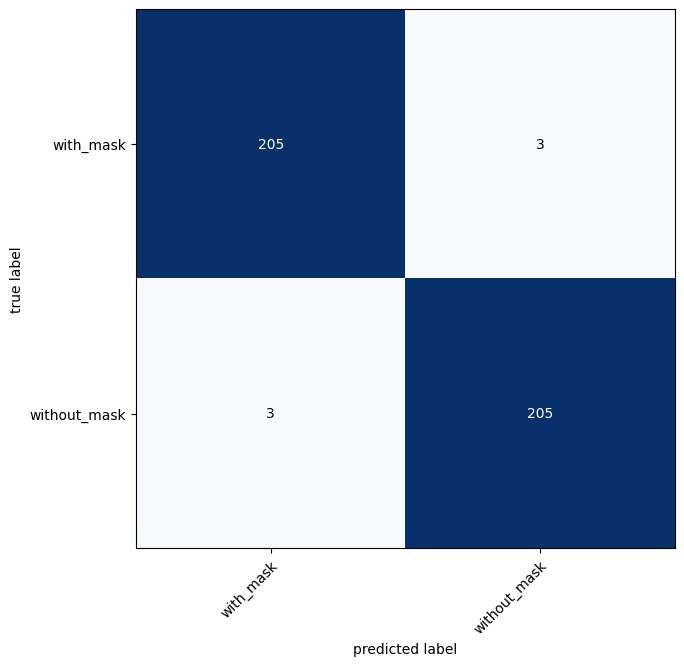

In [ ]:
confusion_matrix(predictions_tensor_model, labels_tensor_model, class_names)

In [ ]:
plot_precision_recall_curves_binary(probabilities_tensor_model, labels_tensor_model)

In [ ]:
def plot_wrong_predictions(y_pred_tensor, test_data):
  y_pred_tensor = y_pred_tensor.int().numpy()
  test_data_targets_array = np.array(test_data.targets)

  wrong_pred_indexes = np.where(y_pred_tensor != test_data_targets_array)[0]
  print("The number of wrong predictions is:", len(wrong_pred_indexes))

  # Select random 16 wrong predictions and plot them
  random_selection = random.sample(list(wrong_pred_indexes), k=len(wrong_pred_indexes))

  plt.figure(figsize=(20, 20))

  for i, idx in enumerate(random_selection):
    # Get true and pred labels
    true_label = class_names[test_data[idx][1]]
    pred_label = class_names[y_pred_tensor[idx]]

    # Plot the wrong prediction with its original label
    plt.subplot(5, 5, i+1)
    plt.imshow(test_data[idx][0].squeeze().permute(2, 1, 0))
    plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
    plt.axis(False);

The number of wrong predictions is: 6


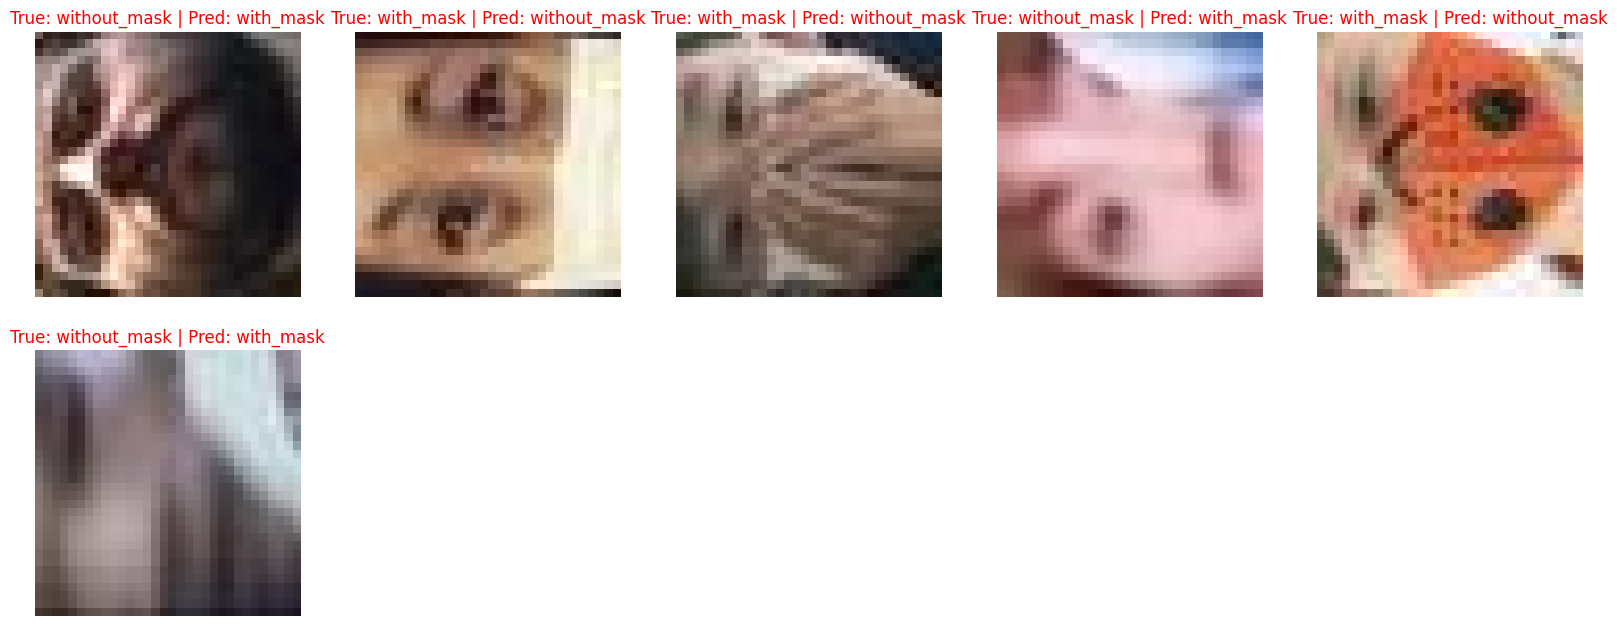

In [ ]:
plot_wrong_predictions(predictions_tensor_model, test_data)

### Test on mask_incorrect_use images

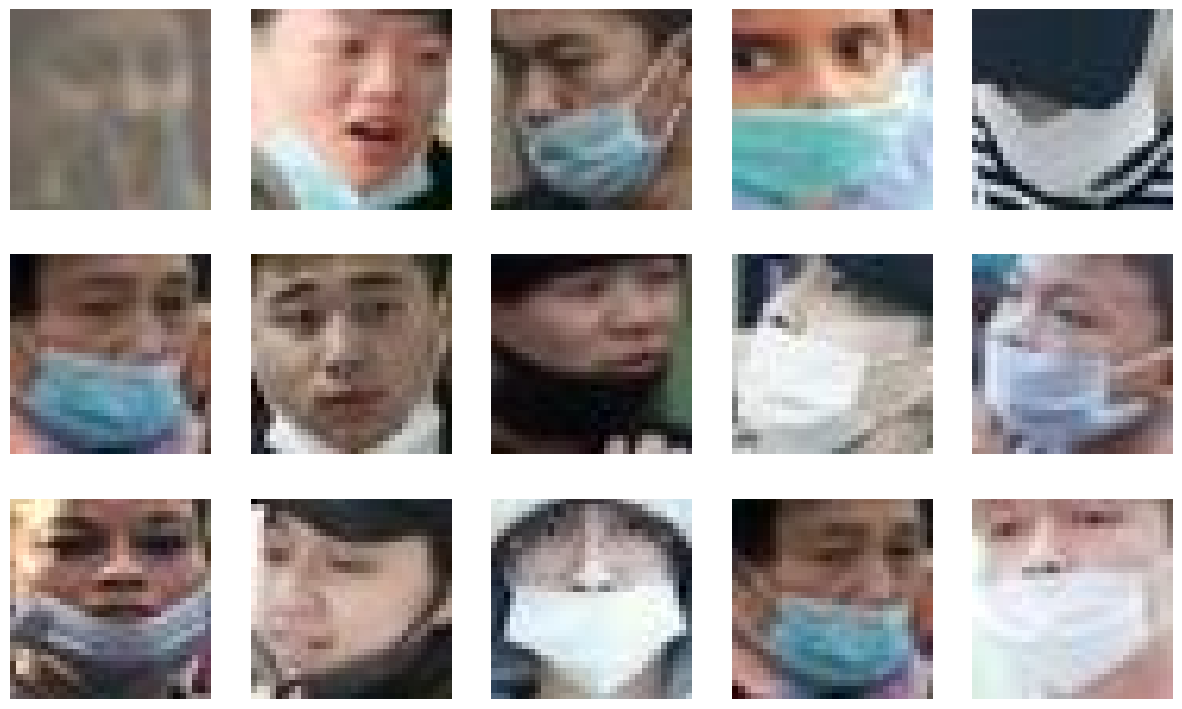

In [ ]:
mask_incorrect_use_path = "/content/Data Τελικής Εργασίας/Mask_DB/mask_incorrect_use"

# Initialize a list to store images
images = []

# Iterate over all files in the directory
for filename in os.listdir(mask_incorrect_use_path):
  if filename.endswith(".jpg") or filename.endswith(".png"):
      image_path = os.path.join(mask_incorrect_use_path, filename)

      # Load and preprocess the image
      custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.

      # Append the preprocessed image to the list
      images.append(custom_image)

# Plot 15 images
plt.figure(figsize=(15, 9))

for i in range(15):
  plt.subplot(3, 5, i + 1)
  plt.imshow(images[i].permute(1, 2, 0))
  plt.axis(False)
plt.show()

In [ ]:
def predict_class(model, images):
  predicted_classes = []
  model.eval()
  with torch.inference_mode():
    for custom_image in images:
      # Add an extra dimension to image
      custom_image_with_batch_size = custom_image.unsqueeze(dim=0)

      # Print out different shapes
      # print(f"Custom image transformed shape: {custom_image_transformed.shape}")
      # print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}\n")

      # Make a prediction on image with an extra dimension
      custom_image_pred = model(custom_image_with_batch_size.to(device))
      # print(f"Prediction logits: {custom_image_pred}")

      # Convert logits -> prediction probabilities (using torch.sigmoid() for binary-class classification)
      custom_image_pred_probs = torch.sigmoid(custom_image_pred)
      # print(f"Prediction probabilities: {custom_image_pred_probs}")

      # Convert prediction probabilities -> prediction labels
      custom_image_pred_label = torch.round(custom_image_pred_probs)
      # print(f"Prediction label: {custom_image_pred_label}")

      # Find the predicted class
      custom_image_pred_class = class_names[int(custom_image_pred_label)] # pred label to CPU
      # print(f"Predicted class: {custom_image_pred_class}")

      predicted_classes.append(custom_image_pred_class)
  return predicted_classes

In [ ]:
# Predict class
predicted_classes = predict_class(loaded_model, images)

# Count the number of images without masks
count_without_mask = predicted_classes.count('without_mask')
print("Number of images without masks:", count_without_mask)

# Count the number of images with masks
count_with_mask = predicted_classes.count('with_mask')
print("Number of images with masks:", count_with_mask)

Number of images without masks: 9
Number of images with masks: 47


In [ ]:
acc = count_without_mask/(count_without_mask+count_with_mask)
print(f"Accuracy in mask incorrect use is: {acc*100:.06}%")
err = 1 - acc
print(f"Classification error in mask incorrect use is: {err:.04}")
print(f"Classification error in mask incorrect use is: {err*100:.06}%")

Accuracy in mask incorrect use is: 16.0714%
Classification error in mask incorrect use is: 0.8393
Classification error in mask incorrect use is: 83.9286%


#### Lower the threshold

In [ ]:
def predict_class_with_threshold(model, images, threshold):
  # Use threshold
  predicted_classes = []

  model.eval()
  with torch.inference_mode():
    for custom_image in images:
      # Add an extra dimension to image
      custom_image_with_batch_size = custom_image.unsqueeze(dim=0)

      # Print out different shapes
      # print(f"Custom image transformed shape: {custom_image_transformed.shape}")
      # print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}\n")

      # Make a prediction on image with an extra dimension
      custom_image_pred = model(custom_image_with_batch_size.to(device))
      # print(f"Prediction logits: {custom_image_pred}")

      # Convert logits -> prediction probabilities (using torch.sigmoid() for binary-class classification)
      custom_image_pred_probs = torch.sigmoid(custom_image_pred)
      # print(f"Prediction probabilities: {custom_image_pred_probs}")

      # Convert prediction probabilities -> prediction labels
      # custom_image_pred_label = torch.round(custom_image_pred_probs)
      custom_image_pred_label = custom_image_pred_probs >= threshold
      # print(f"Prediction label: {custom_image_pred_label}")

      # Find the predicted class
      custom_image_pred_class = class_names[int(custom_image_pred_label)] # pred label to CPU
      # print(f"Predicted class: {custom_image_pred_class}")

      predicted_classes.append(custom_image_pred_class)
  return predicted_classes

In [ ]:
thresh = 0.1

# Predict classes
predicted_classes = predict_class_with_threshold(loaded_model, images, threshold=thresh)

# Count the number of images without masks
count_without_mask = predicted_classes.count('without_mask')
print("Number of images without masks:", count_without_mask)

# Count the number of images with masks
count_with_mask = predicted_classes.count('with_mask')
print("Number of images with masks:", count_with_mask)

Number of images without masks: 10
Number of images with masks: 46


In [ ]:
acc = count_without_mask/(count_without_mask+count_with_mask)
print(f"Accuracy in mask incorrect use is: {acc*100:.06}%")
err = 1 - acc
print(f"Classification error in mask incorrect use is: {err:.04}")
print(f"Classification error in mask incorrect use is: {err*100:.06}%")

Accuracy in mask incorrect use is: 17.8571%
Classification error in mask incorrect use is: 0.8214
Classification error in mask incorrect use is: 82.1429%


In [ ]:
def eval_step_threshold(model: torch.nn.Module,
                        dataloader: torch.utils.data.DataLoader,
                        loss_fn: torch.nn.Module,
                        threshold):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device, dtype=torch.float)

            # 1. Forward pass
            val_pred_logits = model(X).squeeze()

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_probs = torch.sigmoid(val_pred_logits)
            val_pred_labels = val_pred_probs >= threshold # turn pred probs -> pred labls

            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [ ]:
def test_threshold(model: torch.nn.Module,
                   test_dataloader: torch.utils.data.DataLoader,
                   optimizer: torch.optim.Optimizer,
                   loss_fn: torch.nn.Module,
                   threshold):

    # Create empty results dictionary
    results = {"test_loss": [],
               "test_acc": []
               }

    test_loss, test_acc = eval_step_threshold(model=model,
                                              dataloader=test_dataloader,
                                              loss_fn=loss_fn,
                                              threshold=threshold)

    # Print out what's happening
    print(f"test_loss: {test_loss:.4f} | "f"test_acc: {test_acc:.4f}")

    # Update results dictionary
    results["test_loss"] = test_loss
    results["test_acc"] = test_acc

    # Return the filled results at the end of the epochs
    return results

In [ ]:
# Test model
loaded_model_test_results = test_threshold(model=loaded_model,
                                           test_dataloader=test_dataloader,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           threshold=thresh)

test_loss: 0.0692 | test_acc: 0.9832


In [ ]:
def make_predictions_threshold(model: torch.nn.Module,
                               test_dataloader: torch.utils.data.DataLoader,
                               optimizer: torch.optim.Optimizer,
                               loss_fn: torch.nn.Module,
                               threshold):

  # Make predictions with trained model
  y_preds = []
  y_probs = []
  y_labels = []
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
      # Send data and targets to target device
      X, y = X.to(device), y.to(device)
      y_label = y
      # Do the forward pass
      y_logit = model(X).squeeze()
      # Turn predictions from logits -> prediction probabilities -> predictions labels
      y_prob = torch.sigmoid(y_logit)
      y_pred = y_prob >= threshold # Use threshold
      # Put predictions on CPU for evaluation
      y_preds.append(y_pred.cpu())
      y_probs.append(y_prob.cpu())
      y_labels.append(y_label.cpu())
  # Concatenate list of predictions and probabilities into a tensor
  y_pred_tensor = torch.cat(y_preds)
  y_prob_tensor = torch.cat(y_probs)
  y_label_tensor = torch.cat(y_labels)
  return y_pred_tensor, y_prob_tensor, y_label_tensor

In [ ]:
# Make Predictios, use the unshuffled dataloader
predictions_tensor_model, probabilities_tensor_model, labels_tensor_model = make_predictions_threshold(model=loaded_model,
                                                                                                       test_dataloader=original_test_dataloader,
                                                                                                       optimizer=optimizer,
                                                                                                       loss_fn=loss_fn,
                                                                                                       threshold=thresh)

Making predictions:   0%|          | 0/13 [00:00<?, ?it/s]

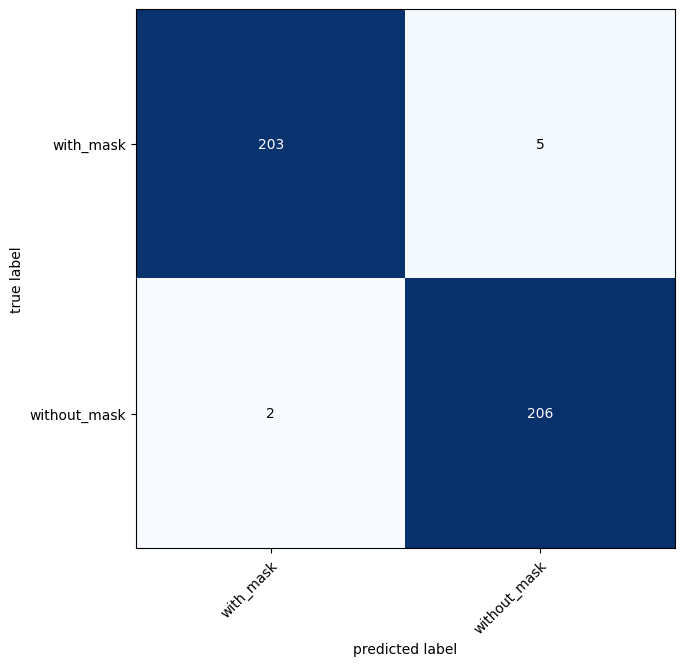

In [ ]:
confusion_matrix(predictions_tensor_model, labels_tensor_model, class_names)

#### Use more images without masks at training

In [ ]:
folder_path = "/content/Data Τελικής Εργασίας/Mask_DB"

In [ ]:
# Split percentages
train_per = 0.6 # 60%
val_per = 0.2 # 20%
test_per = 0.2 # 20%

train_per_with_mask = 0.4
val_per_with_mask = 0.3
test_per_with_mask = 0.3

# Get the list of files in each directory
with_mask_dir = folder_path + "/with_mask"
without_mask_dir = folder_path + "/without_mask"
with_mask_files = os.listdir(with_mask_dir)
without_mask_files = os.listdir(without_mask_dir)

# Calculate the number of files for the training, validation, and test sets
num_train_with_mask = math.ceil(train_per_with_mask * len(with_mask_files))
num_val_with_mask = math.ceil(val_per_with_mask * len(with_mask_files))
num_test_with_mask = len(with_mask_files) - num_train_with_mask - num_val_with_mask

num_train_without_mask = math.ceil(train_per * len(without_mask_files))
num_val_without_mask = math.ceil(val_per * len(without_mask_files))
num_test_without_mask = len(without_mask_files) - num_train_without_mask - num_val_without_mask


# Randomly select files for the training, validation, and test sets
train_with_mask_files, temp_with_mask_files = random_split(with_mask_files, [num_train_with_mask, len(with_mask_files) - num_train_with_mask])
val_with_mask_files, test_with_mask_files = random_split(temp_with_mask_files, [num_val_with_mask, num_test_with_mask])

train_without_mask_files, temp_without_mask_files = random_split(without_mask_files, [num_train_without_mask, len(without_mask_files) - num_train_without_mask])
val_without_mask_files, test_without_mask_files = random_split(temp_without_mask_files, [num_val_without_mask, num_test_without_mask])

In [ ]:
# Create train directory
train_dir = folder_path + "/split_dataset/train_dir_new_without_masks"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(train_dir+"/with_mask", exist_ok=True)
os.makedirs(train_dir+"/without_mask", exist_ok=True)

# Create val directory
val_dir = folder_path + "/split_dataset/val_dir_new_without_masks"
os.makedirs(val_dir, exist_ok=True)
os.makedirs(val_dir+"/with_mask", exist_ok=True)
os.makedirs(val_dir+"/without_mask", exist_ok=True)

# Create test directory
test_dir = folder_path + "/split_dataset/test_dir_new_without_masks"
os.makedirs(test_dir, exist_ok=True)
os.makedirs(test_dir+"/with_mask", exist_ok=True)
os.makedirs(test_dir+"/without_mask", exist_ok=True)


# Copy files to the training set
copy_images(with_mask_dir, train_dir+"/with_mask", train_with_mask_files)
copy_images(without_mask_dir, train_dir+"/without_mask", train_without_mask_files)

# Copy files to the validation set
copy_images(with_mask_dir, val_dir+"/with_mask", val_with_mask_files)
copy_images(without_mask_dir, val_dir+"/without_mask", val_without_mask_files)

# Copy files to the test set
copy_images(with_mask_dir, test_dir+"/with_mask", test_with_mask_files)
copy_images(without_mask_dir, test_dir+"/without_mask", test_without_mask_files)

In [ ]:
folder_path = "/content/Data Τελικής Εργασίας/Mask_DB/split_dataset"
walk_through_dir(folder_path)

There are 6 directories and 0 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset'.
There are 2 directories and 0 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/val_dir_new_without_masks'.
There are 0 directories and 209 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/val_dir_new_without_masks/without_mask'.
There are 0 directories and 314 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/val_dir_new_without_masks/with_mask'.
There are 2 directories and 0 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/test_dir'.
There are 0 directories and 208 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/test_dir/without_mask'.
There are 0 directories and 208 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/test_dir/with_mask'.
There are 2 directories and 0 images in '/content/Data Τελικής Εργασίας/Mask_DB/split_dataset/train_dir'.
There are 0 directories and 627 images in '/content/Data Τελική

In [ ]:
# Use ImageFolder to create datasets, with image augmentations
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

val_data = datasets.ImageFolder(root=val_dir,
                                transform=val_transform,
                                target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

# Without image augmentations, test_transform has no augmentation
original_train_data = datasets.ImageFolder(root=train_dir,
                                           transform=test_transform,
                                           target_transform=None)

# Print the sizes of the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 1045
Validation set size: 523
Test set size: 520


In [ ]:
# Turn datasets into batches (DataGenerators)
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=True)

val_dataloader = DataLoader(val_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS,
                             pin_memory=True)

# Without augmentations
original_train_dataloader = DataLoader(original_train_data,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       num_workers=NUM_WORKERS,
                                       pin_memory=True)

# Without shuffling
original_test_dataloader = DataLoader(test_data,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=NUM_WORKERS,
                                      pin_memory=True)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} images")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE} images")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} images")

Length of train dataloader: 33 batches of 32 images
Length of val dataloader: 17 batches of 32 images
Length of test dataloader: 17 batches of 32 images


In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = ModelV5(input_shape=img_Channels, output_shape=1).to(device)

In [ ]:
# Tune hyperparameters
NUM_EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 0.001

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Create a StepLR scheduler, every 5 epochs lr = lr*gamma
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      patience=PATIENCE,
                      scheduler=scheduler,
                      best_model_path="model_new.pth")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2117 | train_acc: 0.9176 | val_loss: 0.1897 | val_acc: 0.9393| lr: [0.001]
Epoch: 2 | train_loss: 0.0954 | train_acc: 0.9697 | val_loss: 0.0491 | val_acc: 0.9835| lr: [0.001]
Epoch: 3 | train_loss: 0.0781 | train_acc: 0.9716 | val_loss: 0.0738 | val_acc: 0.9744| lr: [0.001]
Epoch: 4 | train_loss: 0.0606 | train_acc: 0.9801 | val_loss: 0.0599 | val_acc: 0.9835| lr: [0.001]
Epoch: 5 | train_loss: 0.0494 | train_acc: 0.9830 | val_loss: 0.0396 | val_acc: 0.9853| lr: [0.001]
Epoch: 6 | train_loss: 0.0372 | train_acc: 0.9905 | val_loss: 0.0390 | val_acc: 0.9871| lr: [0.0005]
Epoch: 7 | train_loss: 0.0244 | train_acc: 0.9915 | val_loss: 0.0612 | val_acc: 0.9816| lr: [0.0005]
Epoch: 8 | train_loss: 0.0394 | train_acc: 0.9867 | val_loss: 0.0391 | val_acc: 0.9853| lr: [0.0005]
Epoch: 9 | train_loss: 0.0211 | train_acc: 0.9938 | val_loss: 0.0552 | val_acc: 0.9835| lr: [0.0005]
Epoch: 10 | train_loss: 0.0138 | train_acc: 0.9943 | val_loss: 0.0527 | val_acc: 0.9818| lr: [0.

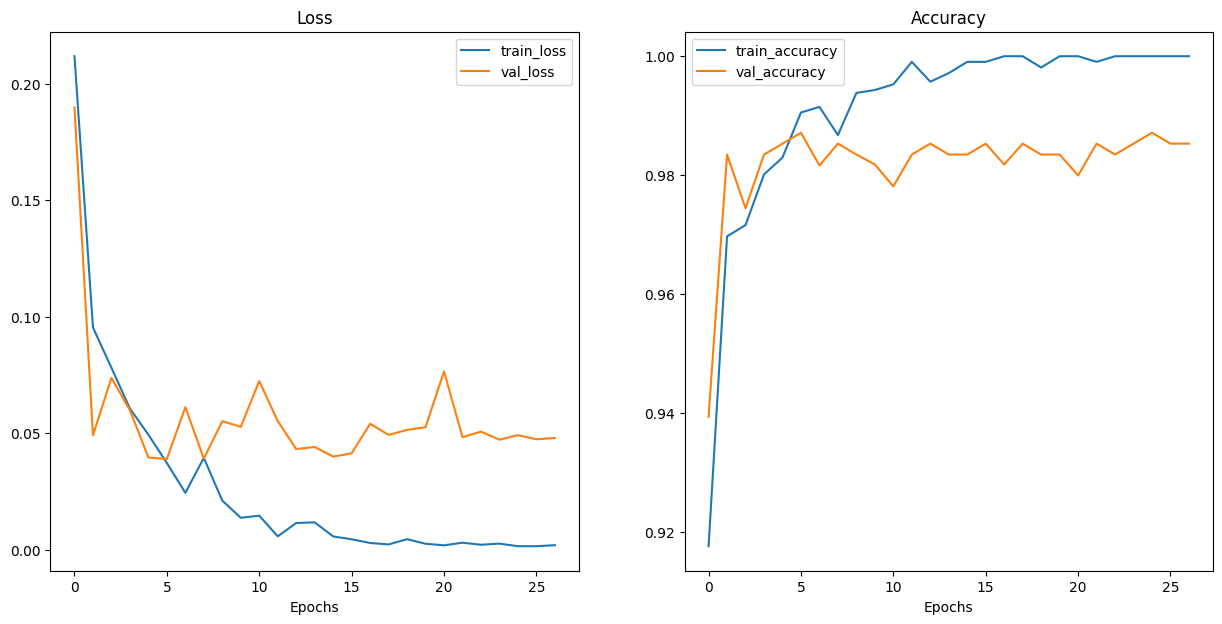

In [ ]:
plot_loss_curves(model_results)

In [ ]:
# Test model
model_test_results = test(model=model,
                          test_dataloader=original_test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn)

test_loss: 0.0592 | test_acc: 0.9724


In [ ]:
# Make Predictios
predictions_tensor_model, probabilities_tensor_model, labels_tensor_model = make_predictions(model=model,
                                                                                             test_dataloader=original_test_dataloader,
                                                                                             optimizer=optimizer,
                                                                                             loss_fn=loss_fn)

Making predictions:   0%|          | 0/17 [00:00<?, ?it/s]

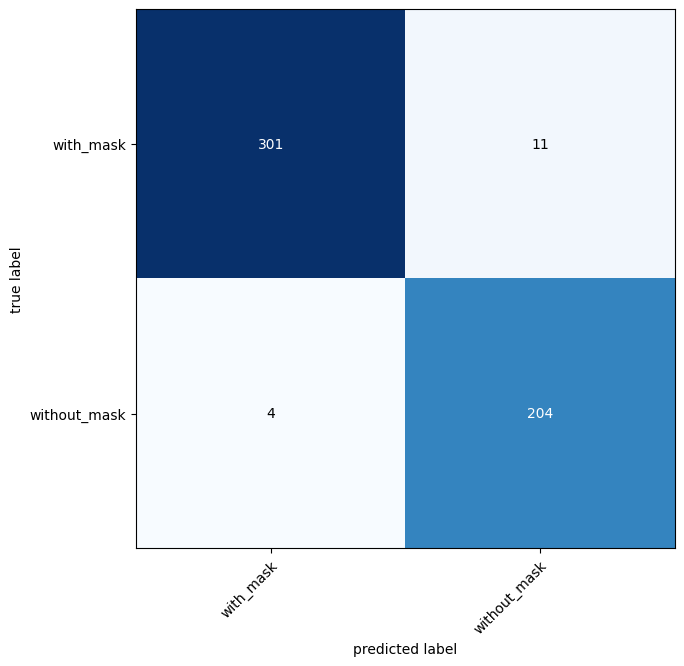

In [ ]:
confusion_matrix(predictions_tensor_model, labels_tensor_model, class_names)

In [ ]:
# Predict class
predicted_classes = predict_class(model, images)

# Count the number of images without masks
count_without_mask = predicted_classes.count('without_mask')
print("Number of images without masks:", count_without_mask)

# Count the number of images with masks
count_with_mask = predicted_classes.count('with_mask')
print("Number of images with masks:", count_with_mask)

Number of images without masks: 12
Number of images with masks: 44


In [ ]:
acc = count_without_mask/(count_without_mask+count_with_mask)
print(f"Accuracy in mask incorrect use is: {acc*100:.06}%")
err = 1 - acc
print(f"Classification error in mask incorrect use is: {err:.04}")
print(f"Classification error in mask incorrect use is: {err*100:.06}%")

Accuracy in mask incorrect use is: 21.4286%
Classification error in mask incorrect use is: 0.7857
Classification error in mask incorrect use is: 78.5714%


##### Lower the threshold

In [ ]:
# Predict classes with threshold
thresh = 0.1
predicted_classes = predict_class_with_threshold(model, images, threshold=thresh)

# Count the number of images without masks
count_without_mask = predicted_classes.count('without_mask')
print("Number of images without masks:", count_without_mask)

# Count the number of images with masks
count_with_mask = predicted_classes.count('with_mask')
print("Number of images with masks:", count_with_mask)

Number of images without masks: 13
Number of images with masks: 43


In [ ]:
acc = count_without_mask/(count_without_mask+count_with_mask)
print(f"Accuracy in mask incorrect use is: {acc*100:.06}%")
err = 1 - acc
print(f"Classification error in mask incorrect use is: {err:.04}")
print(f"Classification error in mask incorrect use is: {err*100:.06}%")

Accuracy in mask incorrect use is: 23.2143%
Classification error in mask incorrect use is: 0.7679
Classification error in mask incorrect use is: 76.7857%


In [ ]:
# Test model
model_test_results = test_threshold(model=model,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    threshold=thresh)

test_loss: 0.0634 | test_acc: 0.9743


In [ ]:
# Make Predictios, use the unshuffled dataloader
predictions_tensor_model, probabilities_tensor_model, labels_tensor_model = make_predictions_threshold(model=model,
                                                                                                       test_dataloader=original_test_dataloader,
                                                                                                       optimizer=optimizer,
                                                                                                       loss_fn=loss_fn,
                                                                                                       threshold=thresh)

Making predictions:   0%|          | 0/17 [00:00<?, ?it/s]

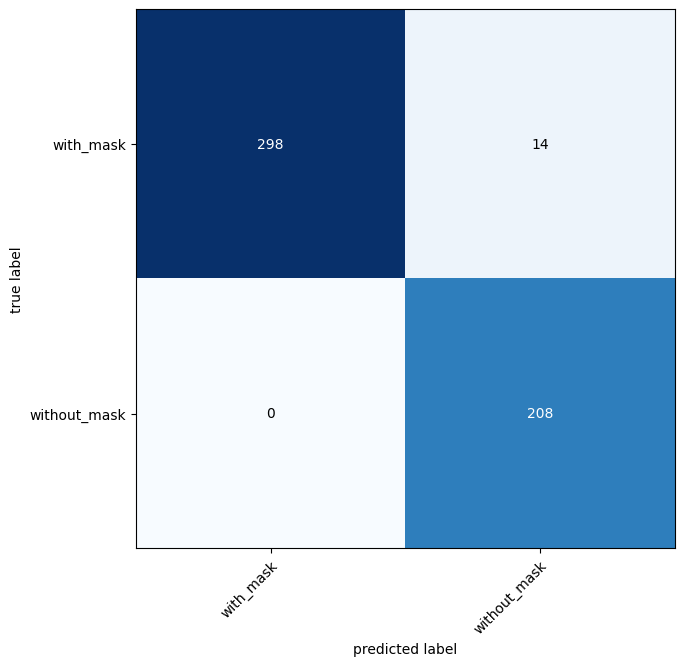

In [ ]:
confusion_matrix(predictions_tensor_model, labels_tensor_model, class_names)